In [1]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
import warnings
warnings.filterwarnings("ignore")

workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
            
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)

'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject,testRun=6):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []

    run=testRun
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}


    def classifierEvidence(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
        # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
        return np.asarray(Evidence)

    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]


    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"

    store="\n"
    print("floor")
    # D evidence for AD_clf when A is presented.
    Y = 'bench'
    AD_clf=joblib.load(model_folder +f'bedchair_bedbench_testRun{testRun}.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_D_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_floor = np.mean(AD_D_evidence)
    print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # C evidence for AC_clf when A is presented.
    Y = 'table'
    AC_clf=joblib.load(model_folder +f'benchtable_tablebed_testRun{testRun}.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_C_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_floor = np.mean(AC_C_evidence)
    print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # D evidence for CD_clf when A is presented.
    Y = 'bench'
    CD_clf=joblib.load(model_folder +f'bedbench_benchtable_testRun{testRun}.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_D_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor1 = np.mean(CD_D_evidence)
    print(f"D evidence for CD_clf when A is presented={evidence_floor1}")
    store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor1}"

    # C evidence for CD_clf when A is presented.
    Y = 'table'
    CD_clf=joblib.load(model_folder +f'bedbench_benchtable_testRun{testRun}.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor2 = np.mean(CD_C_evidence)
    print(f"C evidence for CD_clf when A is presented={evidence_floor2}")
    store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor2}"

    evidence_floor = max(evidence_floor1,evidence_floor2)
    store=store+"\n"+f"max(evidence_floor1,evidence_floor2)={evidence_floor}"

    print("ceil")
    store=store+"\n"+"ceil"
    # evidence_ceil  is A evidence in AC and AD classifier
    Y = 'bed'
    AC_clf=joblib.load(model_folder +f'benchtable_tablebed_testRun{testRun}.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence
    print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    Y = 'bed'
    AD_clf=joblib.load(model_folder +f'bedchair_bedbench_testRun{testRun}.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence
    print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # evidence_ceil = np.mean(evidence_ceil1)
    # evidence_ceil = np.mean(evidence_ceil2)
    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil}")
    store=store+"\n"+f"evidence_ceil={evidence_ceil}"
    ceil,floor=evidence_ceil,evidence_floor
    mu = (ceil+floor)/2
    sig = (ceil-floor)/2.3548
    print(f"floor={floor}, ceil={ceil}")
    print(f"mu={mu}, sig={sig}")

    store=store+"\n"+f"floor={floor}, ceil={ceil}"
    store=store+"\n"+f"mu={mu}, sig={sig}"




    BC_clf=joblib.load(model_folder +f'benchchair_chairtable_testRun{testRun}.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    BD_clf=joblib.load(model_folder +f'bedchair_chairbench_testRun{testRun}.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    
    Y = 'chair'
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    print(f"classifierEvidence(BC_clf,FEAT,Y)={classifierEvidence(BC_clf,FEAT,Y)}")
    print(f"classifierEvidence(BD_clf,FEAT,Y)={classifierEvidence(BD_clf,FEAT,Y)}")





    # # convert item colume to label colume
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    def testMorphParamFor(A): #A='bed''chair'...
        A_ID = (META['label']==A)
        X = FEAT[A_ID]


        # 这里的X是选择的testRun里面的所有的展示A的trials
        BC_B_evidence = classifierEvidence(BC_clf,X,Y)
        BD_B_evidence = classifierEvidence(BD_clf,X,Y)
        print(f"BC_B_evidence={BC_B_evidence}")
        print(f"BD_B_evidence={BD_B_evidence}")
        B_evidence = (BC_B_evidence+BD_B_evidence)/2
        print(f"B_evidence={B_evidence}")
        print(f"mu={mu}, sig={sig}")
        



        def gaussian(x, mu, sig):
            # mu and sig is determined before each neurofeedback session using 2 recognition runs.
            return np.round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (-∞,∞) -> [1,19]
        morphParam=np.mean(gaussian(B_evidence, mu, sig))
        # B_evidences.append(B_evidence)
        print(f"morphParam={morphParam}")
        return f"morphParam for {A} = {morphParam}"

    store=store+"\n"+testMorphParamFor('bed')
    store=store+"\n"+testMorphParamFor('chair')
    store=store+"\n"+testMorphParamFor('table')
    store=store+"\n"+testMorphParamFor('bench')

    return evidence_floor, evidence_ceil,store



'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 
def minimalClass(subject):
    # subject=subjects[1]
    '''
    purpose: 
        train offline models

    steps:
        load preprocessed and aligned behavior and brain data 
        select data with the wanted pattern like AB AC AD BC BD CD 
        train correspondng classifier and save the classifier performance and the classifiers themselves.

    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression

    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

    def jitter(size,const=0):
        jit = np.random.normal(0+const, 0.05, size)
        X = np.zeros((size))
        X = X + jit
        return X

    def other(target):
        other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
        return other_objs

    def red_vox(n_vox, prop=0.1):
        return int(np.ceil(n_vox * prop))

    def get_inds(X, Y, pair, testRun=None):

        inds = {}

        # return relative indices
        if testRun:
            trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
        else:
            trainIX = Y.index[(Y['label'].isin(pair))]

        # pull training and test data
        trainX = X[trainIX]
        trainY = Y.iloc[trainIX].label

        # Main classifier on 5 runs, testing on 6th
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)
        B = clf.coef_[0]  # pull betas

        # retrieve only the first object, then only the second object
        if testRun:
            obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
            obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
        else:
            obj1IX = Y.index[(Y['label'] == pair[0])]
            obj2IX = Y.index[(Y['label'] == pair[1])]

        # Get the average of the first object, then the second object
        obj1X = np.mean(X[obj1IX], 0)
        obj2X = np.mean(X[obj2IX], 0)

        # Build the importance map
        mult1X = obj1X * B
        mult2X = obj2X * B

        # Sort these so that they are from least to most important for a given category.
        sortmult1X = mult1X.argsort()[::-1]
        sortmult2X = mult2X.argsort()

        # add to a dictionary for later use
        inds[clf.classes_[0]] = sortmult1X
        inds[clf.classes_[1]] = sortmult2X

        return inds

    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    objects = ['bed', 'bench', 'chair', 'table']


    if dataSource == "neurosketch":
        funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
    elif dataSource == "realtime":
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
        anat = "$TO_BE_FILLED"
    else:
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "$TO_BE_FILLED"

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))
    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    print(f"np.sum(chosenMask)={np.sum(chosenMask)}")
    # Compile preprocessed data and corresponding indices
    metas = []
    for run in range(1, 7):
        print(run, end='--')
        # retrieve from the dictionary which phase it is, assign the session
        phase = phasedict[run]
        
        # Build the path for the preprocessed functional data
        this4d = funcdata.format(run=run, phase=phase, sub=subject)
        
        # Read in the metadata, and reduce it to only the TR values from this run, add to a list
        thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
        if dataSource == "neurosketch":
            _run = 1 if run % 2 == 0 else 2
        else:
            _run = run
        thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
        if dataSource == "realtime":
            TR_num = list(thismeta.TR.astype(int))
            labels = list(thismeta.Item)
            labels = [imcodeDict[label] for label in labels]
        else:
            TR_num = list(thismeta.TR_num.astype(int))
            labels = list(thismeta.label)
        
        print("LENGTH OF TR: {}".format(len(TR_num)))
        # Load the functional data
        runIm = nib.load(this4d)
        affine_mat = runIm.affine
        runImDat = runIm.get_fdata()
        
        # Use the TR numbers to select the correct features
        features = [runImDat[:,:,:,n+3] for n in TR_num] # here shape is from (94, 94, 72, 240) to (80, 94, 94, 72)
        features = np.array(features)
        features = features[:, chosenMask==1]
        print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
        features = normalize(features)
        # features = np.expand_dims(features, 0)
        
        # Append both so we can use it later
        # metas.append(labels)
        # metas['label']

        t=pd.DataFrame()
        t['label']=labels
        t["run_num"]=run
        behav_data=t if run==1 else pd.concat([behav_data,t])
        
        runs = features if run == 1 else np.concatenate((runs, features))

    dimsize = runIm.header.get_zooms()
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    def Class(brain_data,behav_data):
        accs = []
        for run in range(1,7):
            trainIX = behav_data['run_num']!=int(run)
            testIX = behav_data['run_num']==int(run)

            trainX =  brain_data[trainIX]
            trainY =  behav_data.iloc[np.asarray(trainIX)].label

            testX =  brain_data[testIX]
            testY =  behav_data.iloc[np.asarray(testIX)].label

            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                    multi_class='multinomial').fit(trainX, trainY)

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            accs.append(acc)
        accs
        return np.mean(accs)
    accs=Class(brain_data,behav_data)
    print(f"new trained 4 way classifier accuracy={accs}")


    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}

    # Which run to use as test data (leave as None to not have test data)
    accs_rotation_container={}
    evidence_rotation_container={}
    for testRun in range(1,7):
        # testRun = 6 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

        # Decide on the proportion of crescent data to use for classification
        include = 1
        objects = ['bed', 'bench', 'chair', 'table']
        allpairs = itertools.combinations(objects,2)
        accs={}
        # Iterate over all the possible target pairs of objects
        for pair in allpairs:
            # Find the control (remaining) objects for this pair
            altpair = other(pair)

            # pull sorted indices for each of the critical objects, in order of importance (low to high)
            # inds = get_inds(FEAT, META, pair, testRun=testRun)

            # Find the number of voxels that will be left given your inclusion parameter above
            # nvox = red_vox(FEAT.shape[1], include)

            for obj in pair:
                # foil = [i for i in pair if i != obj][0]
                for altobj in altpair:

                    # establish a naming convention where it is $TARGET_$CLASSIFICATION
                    # Target is the NF pair (e.g. bed/bench)
                    # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                    naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

                    # Pull the relevant inds from your previously established dictionary 
                    # obj_inds = inds[obj]

                    # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                    # if testRun:
                    #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                    #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                    # else:
                    #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                    #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                    # # pull training and test data
                    # trainX = FEAT[trainIX]
                    # testX = FEAT[testIX]
                    # trainY = META.iloc[trainIX].label
                    # testY = META.iloc[testIX].label

                    # print(f"obj={obj},altobj={altobj}")
                    # print(f"unique(trainY)={np.unique(trainY)}")
                    # print(f"unique(testY)={np.unique(testY)}")
                    # assert len(np.unique(trainY))==2

                    # for testRun in range(6):
                    if testRun:
                        trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                        testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                    else:
                        trainIX = ((META['label']==obj) + (META['label']==altobj))
                        testIX = ((META['label']==obj) + (META['label']==altobj))
                    # pull training and test data
                    trainX = FEAT[trainIX]
                    testX = FEAT[testIX]
                    trainY = META.iloc[np.asarray(trainIX)].label
                    testY = META.iloc[np.asarray(testIX)].label

                    # print(f"obj={obj},altobj={altobj}")
                    # print(f"unique(trainY)={np.unique(trainY)}")
                    # print(f"unique(testY)={np.unique(testY)}")
                    assert len(np.unique(trainY))==2

                    # # If you're selecting high-importance features, this bit handles that
                    # if include < 1:
                    #     trainX = trainX[:, obj_inds[-nvox:]]
                    #     testX = testX[:, obj_inds[-nvox:]]

                    # Train your classifier
                    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                            multi_class='multinomial').fit(trainX, trainY)


                    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
                    mkdir(model_folder)
                    # Save it for later use
                    joblib.dump(clf, model_folder +f'/{naming}_testRun{testRun}.joblib')

                    # Monitor progress by printing accuracy (only useful if you're running a test set)
                    acc = clf.score(testX, testY)
                    # print(naming, acc)
                    accs[naming]=acc
        accs_rotation_container[testRun] = accs
        evidence_rotation_container[testRun] = morphingTarget(subject,testRun=testRun)
    # for testRun in range(1,7):
    #     t=np.mean(list(accs_rotation_container[testRun].values()))
    #     print(f"testRun {testRun} mean testing accracy={t}")
    #     print(evidence_rotation_container[testRun][2])


    def getString(string,searchFor,end):
        return string.split(searchFor)[1].split(end)[0]
    # getString(string,searchFor)

    floors=[]
    ceils=[]
    for testRun in range(1,7):
        t=np.mean(list(accs_rotation_container[testRun].values()))
        print(f"testRun {testRun} mean testing accracy={t}")
        # print(evidence_rotation_container[testRun][2])
        t=np.float(getString(evidence_rotation_container[testRun][2],"\nfloor=",","))
        print("floor=",t)
        floors.append(t)
        
        t=np.float(getString(evidence_rotation_container[testRun][2],", ceil=","\n"))
        print("ceiling=",t)
        ceils.append(t)
        print()
        print()
    print("np.mean(floors)=",np.mean(floors))
    print("np.mean(ceils)=",np.mean(ceils))

    # _=plt.figure()
    # _=plt.hist(list(accs.values()))

    return accs_rotation_container , evidence_rotation_container



    


# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]





def subLoop(subject):
    # data={}
    accs_rotation_container , evidence_rotation_container = minimalClass(subject)
    # print("best 4way classifier accuracy = ",GreedyBestAcc[subject][bestID[subject]])
    # data['best 4way classifier accuracy']=GreedyBestAcc[subject][bestID[subject]]
    # for acc in accs:
    #     print(acc,accs[acc])
    # data["accs"]=accs
    # floor, ceil,store = morphingTarget(subject,testRun=6)
    # data["store testing run"]=store
    # floor, ceil,store = morphingTarget(subject,testRun=1)
    # data["store training run"]=store
    
    # save_obj(store,f"./{subject}store")
    return accs_rotation_container , evidence_rotation_container


from tqdm import tqdm
data={}
for subject in tqdm(subjects):
    data[subject]=subLoop(subject)




def getCeilFLoor(a):
    accs_rotation_container , evidence_rotation_container = a

    floors=[]
    ceils=[]
    for testRun in range(1,7):
        t=np.float(getString(evidence_rotation_container[testRun][2],"\nfloor=",","))
        floors.append(t)
        t=np.float(getString(evidence_rotation_container[testRun][2],", ceil=","\n"))
        ceils.append(t)

    print(np.mean(floors))
    print(np.mean(ceils))
    return np.mean(floors),np.mean(ceils)

floors=[]
ceilings=[]
for subject in subjects:
    floor,ceiling = getCeilFLoor(data[subject])
    floors.append(floor)
    ceilings.append(ceiling)

plt.plot(floors,label='floor')
plt.plot(ceilings,label="ceiling")
plt.legend()
plt.xlabel("subjects")
plt.ylabel("evidence")



# # floorCeilNeurosketch_child.sh
# #!/usr/bin/env bash
# # Input python command to be submitted as a job
# #SBATCH --output=logs/floorCeil-%j.out
# #SBATCH --job-name floorCeil
# #SBATCH --partition=short,day,scavenge,verylong
# #SBATCH --time=1:00:00 #20:00:00
# #SBATCH --mem=10000
# #SBATCH -n 5

# # Set up the environment

# subject=$1

# echo source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
# source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud

# python -u ./floorCeilNeurosketch.py $subject




# # floorCeilNeurosketch_parent.sh
# subjects="1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172" #these subjects are done with the batchRegions code
# for sub in $subjects
# do
#   for num in 25; #best ID is 30 thus the best num is 31
#   do
#     echo sbatch --requeue floorCeilNeurosketch_child.sh $sub
#     sbatch --requeue floorCeilNeurosketch_child.sh $sub
#   done
# done


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


  0%|          | 0/25 [00:00<?, ?it/s]

np.sum(chosenMask)=4927
1--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 4927) shape of chosenMask (94, 94, 72)
(480, 4927)
(480, 2)
FEAT.shape=(480, 4927)
new trained 4 way classifier accuracy=0.3520833333333333
1--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=-0.1357277666912687
C evidence for AC_clf when A is presented=-0.03784395376229712
D evidence for CD_clf when A is presented=-0.16045974496135068
C evidence for CD_clf when A is presented=0.16045974496135068
ceil
A evi

3--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=-0.150199495327568
C evidence for AC_clf when A is presented=-0.07896384512443176
D evidence for CD_clf when A is presented=-0.04814075988941907
C evidence for CD_clf when A is presented=0.04814075988941907
ceil
A evidence in AC_clf when A is presented=0.07896384512443176
A evidence in AD_clf when A is presented=0.150199495327568
evidence_ceil=0.11458167022599985
floor=0.04814075988941907, ceil=0.11458167022599985
mu=0.08136121505770946, sig=0.028215096966443344
classifierEvidence(BC_clf,FEAT,Y)=[[-0.68207507]
 [-0.32186439]
 [-2.85227508]
 [-0.33041541]
 [-0.15933125]
 [ 1.11557257]
 [-0.13394185]
 [-0.52066418]
 [ 0.35830645]
 [-1.72099139]
 [-0.27908505]
 [ 1.07914562]
 [ 0.81446953]
 [ 0.11625107]
 [ 0.41381009]
 [ 1.25331864]
 [ 0.82517762]
 [-0.7659977 ]
 [-1.10122765]
 [-0.0928911 ]
 [ 1.39604722]
 [-1.16200749]
 [ 0

5--LENGTH OF TR: 80
shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=-0.31368973396055566
C evidence for AC_clf when A is presented=-0.16377982348857495
D evidence for CD_clf when A is presented=-0.1310491252574316
C evidence for CD_clf when A is presented=0.1310491252574316
ceil
A evidence in AC_clf when A is presented=0.16377982348857495
A evidence in AD_clf when A is presented=0.31368973396055566
evidence_ceil=0.23873477872456533
floor=0.1310491252574316, ceil=0.23873477872456533
mu=0.18489195199099845, sig=0.04573027580564538
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.37668271]
 [ 3.16603875]
 [ 2.08774617]
 [ 3.42411574]
 [ 2.45356633]
 [ 2.41122372]
 [ 1.69783245]
 [ 1.72822235]
 [ 1.11430879]
 [ 2.16866952]
 [ 0.89475605]
 [ 1.52578878]
 [ 1.84404972]
 [ 1.11717359]
 [ 1.95000183]
 [ 0.03287022]
 [ 0.78811807]
 [ 1.55525269]
 [-0.63655266]
 [ 1.54466682]
 [-0.85100494]
 [ 0.22872602]
 [ 0

  4%|▍         | 1/25 [04:54<1:57:51, 294.66s/it]

shape of features (80, 4927) shape of mask (94, 94, 72)
(80, 4927)
(80, 2)
FEAT.shape=(80, 4927)
floor
D evidence for AD_clf when A is presented=-0.28403150374256286
C evidence for AC_clf when A is presented=-0.08419816188336389
D evidence for CD_clf when A is presented=-0.1040101817607326
C evidence for CD_clf when A is presented=0.1040101817607326
ceil
A evidence in AC_clf when A is presented=0.08419816188336389
A evidence in AD_clf when A is presented=0.28403150374256286
evidence_ceil=0.1841148328129634
floor=0.1040101817607326, ceil=0.1841148328129634
mu=0.144062507286848, sig=0.03401760279099321
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.3710985 ]
 [-0.26933794]
 [-1.29443766]
 [-0.48907467]
 [ 0.51176747]
 [ 0.94729374]
 [-1.13527576]
 [-1.34235417]
 [ 0.38734985]
 [-0.76875276]
 [-0.13564614]
 [ 0.86744742]
 [ 0.46313021]
 [ 0.08375515]
 [-0.17943085]
 [-0.4851268 ]
 [ 1.20167094]
 [ 1.20290167]
 [ 0.21921218]
 [ 0.88492599]
 [-1.49935934]
 [ 1.86395713]
 [ 0.91451205]
 [-0.02685666

shape of features (80, 3488) shape of chosenMask (94, 94, 72)
(480, 3488)
(480, 2)
FEAT.shape=(480, 3488)
new trained 4 way classifier accuracy=0.325
1--LENGTH OF TR: 80
shape of features (80, 3488) shape of mask (94, 94, 72)
(80, 3488)
(80, 2)
FEAT.shape=(80, 3488)
floor
D evidence for AD_clf when A is presented=0.23461978450701296
C evidence for AC_clf when A is presented=0.14289027895319031
D evidence for CD_clf when A is presented=0.041187208488194973
C evidence for CD_clf when A is presented=-0.041187208488194973
ceil
A evidence in AC_clf when A is presented=-0.14289027895319031
A evidence in AD_clf when A is presented=-0.23461978450701296
evidence_ceil=-0.1887550317301016
floor=0.041187208488194973, ceil=-0.1887550317301016
mu=-0.07378391162095332, sig=-0.09764830992793297
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.53189124e+00]
 [-8.92958665e-02]
 [ 8.95338768e-01]
 [ 6.18519941e-02]
 [ 1.26789582e+00]
 [ 3.70349569e-02]
 [ 3.28764348e-01]
 [ 1.67741979e+00]
 [ 1.09820330e+00]
 [ 2.

3--LENGTH OF TR: 80
shape of features (80, 3488) shape of mask (94, 94, 72)
(80, 3488)
(80, 2)
FEAT.shape=(80, 3488)
floor
D evidence for AD_clf when A is presented=0.044416558920296514
C evidence for AC_clf when A is presented=-0.23269438753324295
D evidence for CD_clf when A is presented=0.21619323253723227
C evidence for CD_clf when A is presented=-0.21619323253723227
ceil
A evidence in AC_clf when A is presented=0.23269438753324295
A evidence in AD_clf when A is presented=-0.044416558920296514
evidence_ceil=0.09413891430647328
floor=0.21619323253723227, ceil=0.09413891430647328
mu=0.1551660734218528, sig=-0.05183213785916383
classifierEvidence(BC_clf,FEAT,Y)=[[-0.32339743]
 [-0.42488034]
 [-1.25318818]
 [ 0.43360643]
 [-1.04818807]
 [ 0.26926829]
 [-0.9335997 ]
 [-1.69221747]
 [-0.50184114]
 [ 0.9374756 ]
 [-0.35996486]
 [ 0.19910278]
 [-0.11637482]
 [ 0.39689232]
 [ 0.35918041]
 [ 0.18148508]
 [-0.46636506]
 [-1.20069882]
 [-1.75512203]
 [-1.79976467]
 [-0.98517091]
 [-0.89074992]

5--LENGTH OF TR: 80
shape of features (80, 3488) shape of mask (94, 94, 72)
(80, 3488)
(80, 2)
FEAT.shape=(80, 3488)
floor
D evidence for AD_clf when A is presented=-0.04853285256117461
C evidence for AC_clf when A is presented=0.23851037821741192
D evidence for CD_clf when A is presented=-0.35076767949218807
C evidence for CD_clf when A is presented=0.35076767949218807
ceil
A evidence in AC_clf when A is presented=-0.23851037821741192
A evidence in AD_clf when A is presented=0.04853285256117461
evidence_ceil=-0.09498876282811873
floor=0.35076767949218807, ceil=-0.09498876282811873
mu=0.12788945833203466, sig=-0.18929694340084371
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.89071038]
 [-2.10368595]
 [-0.00987508]
 [ 0.77470611]
 [-1.27448523]
 [-1.32369204]
 [-0.28597639]
 [-0.84203637]
 [-0.54710305]
 [ 0.41585874]
 [ 0.07118975]
 [ 2.40992583]
 [ 0.77714601]
 [ 0.14728181]
 [ 0.86867071]
 [-1.76761461]
 [-1.07638271]
 [-0.24538902]
 [ 0.13267409]
 [-0.57745203]
 [ 1.34367536]
 [-1.29263393

  8%|▊         | 2/25 [08:41<1:37:42, 254.91s/it]

shape of features (80, 3488) shape of mask (94, 94, 72)
(80, 3488)
(80, 2)
FEAT.shape=(80, 3488)
floor
D evidence for AD_clf when A is presented=-0.051884448218457516
C evidence for AC_clf when A is presented=-0.01705912876212199
D evidence for CD_clf when A is presented=-0.0047471010805816725
C evidence for CD_clf when A is presented=0.0047471010805816725
ceil
A evidence in AC_clf when A is presented=0.01705912876212199
A evidence in AD_clf when A is presented=0.051884448218457516
evidence_ceil=0.03447178849028972
floor=0.0047471010805816725, ceil=0.03447178849028972
mu=0.019609444785435696, sig=0.01262301996335487
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.52945157]
 [ 0.70314284]
 [ 0.93367031]
 [ 0.93154667]
 [ 0.40969251]
 [ 0.51889602]
 [ 0.3066864 ]
 [-0.17844558]
 [ 2.61304183]
 [ 0.58018804]
 [-0.66315555]
 [ 0.1247581 ]
 [ 0.93647843]
 [-1.58408424]
 [-0.87011253]
 [ 1.94625254]
 [ 0.682732  ]
 [ 0.27916513]
 [-0.17200064]
 [-0.13034663]
 [-1.79504741]
 [ 1.00895679]
 [ 1.3171267

shape of features (80, 3140) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 3140) shape of chosenMask (94, 94, 72)
(480, 3140)
(480, 2)
FEAT.shape=(480, 3140)
new trained 4 way classifier accuracy=0.3583333333333334
1--LENGTH OF TR: 80
shape of features (80, 3140) shape of mask (94, 94, 72)
(80, 3140)
(80, 2)
FEAT.shape=(80, 3140)
floor
D evidence for AD_clf when A is presented=0.047310039634387735
C evidence for AC_clf when A is presented=-0.11202338889783711
D evidence for CD_clf when A is presented=0.18090837724675982
C evidence for CD_clf when A is presented=-0.18090837724675982
ceil
A evidence in AC_clf when A is presented=0.11202338889783711
A evidence in AD_clf when A is presented=-0.047310039634387735
evidence_ceil=0.03235667463172471
floor=0.18090837724675982, ceil=0.03235667463172471
mu=0.10663252593924226, sig=-0.06308463674835872
classifierEvidence(BC_clf,FEAT,Y)=[[-0.6520296 ]
 [-0.42134761]
 [-0.82856444]
 [-0.71279463]
 [-0.93631512]
 [ 0.645

3--LENGTH OF TR: 80
shape of features (80, 3140) shape of mask (94, 94, 72)
(80, 3140)
(80, 2)
FEAT.shape=(80, 3140)
floor
D evidence for AD_clf when A is presented=-0.3621483375428405
C evidence for AC_clf when A is presented=-0.2749235228322624
D evidence for CD_clf when A is presented=-0.22105531329652503
C evidence for CD_clf when A is presented=0.22105531329652503
ceil
A evidence in AC_clf when A is presented=0.2749235228322624
A evidence in AD_clf when A is presented=0.3621483375428405
evidence_ceil=0.3185359301875514
floor=0.22105531329652503, ceil=0.3185359301875514
mu=0.2697956217420382, sig=0.041396558897157446
classifierEvidence(BC_clf,FEAT,Y)=[[-0.48806756]
 [ 0.17926902]
 [ 0.17863708]
 [-2.54582776]
 [-2.12132613]
 [-2.13610597]
 [-1.24992135]
 [ 2.15392019]
 [-0.51096872]
 [ 1.20431702]
 [-0.05940045]
 [-0.67407038]
 [-1.56750567]
 [ 0.51561134]
 [-0.23938004]
 [ 0.43617273]
 [ 1.13977441]
 [-2.01036437]
 [-0.81688321]
 [-0.74212555]
 [-0.25125048]
 [ 0.14309484]
 [ 0.53

5--LENGTH OF TR: 80
shape of features (80, 3140) shape of mask (94, 94, 72)
(80, 3140)
(80, 2)
FEAT.shape=(80, 3140)
floor
D evidence for AD_clf when A is presented=-0.35312844580640734
C evidence for AC_clf when A is presented=-0.08338697586240863
D evidence for CD_clf when A is presented=-0.28104307793522487
C evidence for CD_clf when A is presented=0.28104307793522487
ceil
A evidence in AC_clf when A is presented=0.08338697586240863
A evidence in AD_clf when A is presented=0.35312844580640734
evidence_ceil=0.21825771083440793
floor=0.28104307793522487, ceil=0.21825771083440793
mu=0.2496503943848164, sig=-0.026662717471045077
classifierEvidence(BC_clf,FEAT,Y)=[[-2.32727276]
 [ 1.81723576]
 [-0.19526798]
 [ 1.25039423]
 [-0.82713093]
 [ 0.28549732]
 [ 0.0574965 ]
 [ 1.1749786 ]
 [ 0.38147128]
 [-0.0365044 ]
 [-1.24695928]
 [ 0.42708951]
 [ 0.02532819]
 [ 0.40474552]
 [ 0.64036901]
 [ 0.09246172]
 [-1.25406899]
 [ 0.53956835]
 [ 1.50837271]
 [-0.03789663]
 [ 0.99392019]
 [-1.54025337]


 12%|█▏        | 3/25 [12:46<1:31:48, 250.37s/it]

shape of features (80, 3140) shape of mask (94, 94, 72)
(80, 3140)
(80, 2)
FEAT.shape=(80, 3140)
floor
D evidence for AD_clf when A is presented=-0.008206036134410222
C evidence for AC_clf when A is presented=0.05725995583293899
D evidence for CD_clf when A is presented=-0.08732330754110029
C evidence for CD_clf when A is presented=0.08732330754110029
ceil
A evidence in AC_clf when A is presented=-0.05725995583293899
A evidence in AD_clf when A is presented=0.008206036134410222
evidence_ceil=-0.024526959849264375
floor=0.08732330754110029, ceil=-0.024526959849264375
mu=0.03139817384591796, sig=-0.04749883955765443
classifierEvidence(BC_clf,FEAT,Y)=[[ 7.24109730e-01]
 [ 2.00670440e+00]
 [ 9.68222890e-03]
 [ 1.80086606e-01]
 [-1.39829887e+00]
 [-1.97791325e+00]
 [-9.54131474e-01]
 [-1.24812457e+00]
 [ 1.21510814e+00]
 [ 5.01853277e-01]
 [ 1.52693503e+00]
 [-5.30308975e-01]
 [-1.83451505e-01]
 [ 4.99329548e-01]
 [-1.18208672e+00]
 [-1.66591836e+00]
 [-2.94519643e-01]
 [-1.38412514e+00]
 [

1--LENGTH OF TR: 80
shape of features (80, 6267) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 6267) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 6267) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 6267) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 6267) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 6267) shape of chosenMask (94, 94, 72)
(480, 6267)
(480, 2)
FEAT.shape=(480, 6267)
new trained 4 way classifier accuracy=0.32083333333333336
1--LENGTH OF TR: 80
shape of features (80, 6267) shape of mask (94, 94, 72)
(80, 6267)
(80, 2)
FEAT.shape=(80, 6267)
floor
D evidence for AD_clf when A is presented=0.18912778039081837
C evidence for AC_clf when A is presented=0.216322022979136
D evidence for CD_clf when A is presented=0.06581755751830497
C evidence for CD_clf when A is presented=-0.06581755751830497
ceil
A evidence in AC_clf when A is 

3--LENGTH OF TR: 80
shape of features (80, 6267) shape of mask (94, 94, 72)
(80, 6267)
(80, 2)
FEAT.shape=(80, 6267)
floor
D evidence for AD_clf when A is presented=-0.13562530822677915
C evidence for AC_clf when A is presented=0.26177140406436994
D evidence for CD_clf when A is presented=-0.37819381279645314
C evidence for CD_clf when A is presented=0.37819381279645314
ceil
A evidence in AC_clf when A is presented=-0.26177140406436994
A evidence in AD_clf when A is presented=0.13562530822677915
evidence_ceil=-0.06307304791879541
floor=0.37819381279645314, ceil=-0.06307304791879541
mu=0.15756038243882886, sig=-0.18739037740583003
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.55373908]
 [ 0.63274798]
 [ 0.66923174]
 [-1.36220769]
 [ 0.40132182]
 [ 1.95702299]
 [ 1.70382332]
 [ 2.3233417 ]
 [ 1.47464425]
 [ 0.88679227]
 [ 1.82819426]
 [ 0.23378934]
 [-0.99065559]
 [ 1.35329092]
 [ 2.57652008]
 [ 2.04112628]
 [ 1.12942826]
 [ 1.55784963]
 [ 0.63185753]
 [ 1.20242607]
 [ 0.93927206]
 [ 0.88710569

5--LENGTH OF TR: 80
shape of features (80, 6267) shape of mask (94, 94, 72)
(80, 6267)
(80, 2)
FEAT.shape=(80, 6267)
floor
D evidence for AD_clf when A is presented=-0.19467989418890377
C evidence for AC_clf when A is presented=-0.062371022787370924
D evidence for CD_clf when A is presented=-0.20304735458828196
C evidence for CD_clf when A is presented=0.20304735458828196
ceil
A evidence in AC_clf when A is presented=0.062371022787370924
A evidence in AD_clf when A is presented=0.19467989418890377
evidence_ceil=0.1285254584881373
floor=0.20304735458828196, ceil=0.1285254584881373
mu=0.16578640653820964, sig=-0.03164680486671678
classifierEvidence(BC_clf,FEAT,Y)=[[-0.58757759]
 [-1.54190587]
 [-0.85492318]
 [-1.51148244]
 [ 1.40055154]
 [ 0.78586329]
 [-0.08342142]
 [-0.29643654]
 [-1.11832387]
 [-0.074815  ]
 [-0.06719284]
 [ 0.17314371]
 [ 0.71177059]
 [-0.26851552]
 [-0.57111662]
 [ 1.09402965]
 [-1.27496189]
 [-0.98732829]
 [ 1.21729556]
 [ 0.65360418]
 [ 0.25384992]
 [-1.20157268]


 16%|█▌        | 4/25 [18:28<1:40:18, 286.59s/it]

shape of features (80, 6267) shape of mask (94, 94, 72)
(80, 6267)
(80, 2)
FEAT.shape=(80, 6267)
floor
D evidence for AD_clf when A is presented=-0.19315217373157179
C evidence for AC_clf when A is presented=-0.1360055950659129
D evidence for CD_clf when A is presented=-0.02608689598450814
C evidence for CD_clf when A is presented=0.02608689598450814
ceil
A evidence in AC_clf when A is presented=0.1360055950659129
A evidence in AD_clf when A is presented=0.19315217373157179
evidence_ceil=0.16457888439874235
floor=0.02608689598450814, ceil=0.16457888439874235
mu=0.09533289019162525, sig=0.058812633095903774
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.02679602]
 [ 0.25937068]
 [ 0.73532313]
 [-0.93567992]
 [ 0.57308263]
 [-0.0813732 ]
 [-0.4059583 ]
 [ 0.34224381]
 [ 0.68303218]
 [ 1.01555345]
 [ 1.03771241]
 [ 0.49891522]
 [ 0.27113927]
 [-0.0097233 ]
 [ 0.16423515]
 [ 2.25737349]
 [-1.01748495]
 [ 0.06215033]
 [ 0.28161897]
 [ 0.84487983]
 [-0.24504714]
 [-0.02356536]
 [-0.2153998 ]
 [-0.63

shape of features (80, 2759) shape of chosenMask (94, 94, 72)
(480, 2759)
(480, 2)
FEAT.shape=(480, 2759)
new trained 4 way classifier accuracy=0.33958333333333335
1--LENGTH OF TR: 80
shape of features (80, 2759) shape of mask (94, 94, 72)
(80, 2759)
(80, 2)
FEAT.shape=(80, 2759)
floor
D evidence for AD_clf when A is presented=-0.11417158821542381
C evidence for AC_clf when A is presented=0.2935223043957312
D evidence for CD_clf when A is presented=-0.4626786216002087
C evidence for CD_clf when A is presented=0.4626786216002087
ceil
A evidence in AC_clf when A is presented=-0.2935223043957312
A evidence in AD_clf when A is presented=0.11417158821542381
evidence_ceil=-0.08967535809015367
floor=0.4626786216002087, ceil=-0.08967535809015367
mu=0.18650163175502749, sig=-0.23456513491182368
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.7576925 ]
 [ 0.46279586]
 [ 0.94915587]
 [ 0.87633937]
 [-1.15128232]
 [ 0.22952857]
 [-0.48826268]
 [ 0.11565533]
 [ 0.83750545]
 [ 0.19595901]
 [ 0.79354027]
 [ 0

3--LENGTH OF TR: 80
shape of features (80, 2759) shape of mask (94, 94, 72)
(80, 2759)
(80, 2)
FEAT.shape=(80, 2759)
floor
D evidence for AD_clf when A is presented=-0.12073195901186703
C evidence for AC_clf when A is presented=-0.020902341128549478
D evidence for CD_clf when A is presented=-0.2138138820955886
C evidence for CD_clf when A is presented=0.2138138820955886
ceil
A evidence in AC_clf when A is presented=0.020902341128549478
A evidence in AD_clf when A is presented=0.12073195901186703
evidence_ceil=0.07081715007020825
floor=0.2138138820955886, ceil=0.07081715007020825
mu=0.14231551608289844, sig=-0.06072563785687971
classifierEvidence(BC_clf,FEAT,Y)=[[-0.25768649]
 [-2.1706982 ]
 [-0.36242585]
 [-2.72357335]
 [-0.04396407]
 [ 0.24210603]
 [-2.86612932]
 [-0.15900099]
 [-0.07531372]
 [-0.94533665]
 [ 0.76444859]
 [ 1.39839137]
 [ 0.0966267 ]
 [-0.02054091]
 [-0.64586735]
 [-0.31421015]
 [-0.35887871]
 [-2.03729383]
 [-1.1626378 ]
 [-0.84115872]
 [-0.94995816]
 [-2.32517197]
 

5--LENGTH OF TR: 80
shape of features (80, 2759) shape of mask (94, 94, 72)
(80, 2759)
(80, 2)
FEAT.shape=(80, 2759)
floor
D evidence for AD_clf when A is presented=-0.23544456039715705
C evidence for AC_clf when A is presented=-0.3091926221607254
D evidence for CD_clf when A is presented=0.10439583611229622
C evidence for CD_clf when A is presented=-0.10439583611229622
ceil
A evidence in AC_clf when A is presented=0.3091926221607254
A evidence in AD_clf when A is presented=0.23544456039715705
evidence_ceil=0.2723185912789412
floor=0.10439583611229622, ceil=0.2723185912789412
mu=0.1883572136956187, sig=0.07131083538586928
classifierEvidence(BC_clf,FEAT,Y)=[[-3.83363824e-01]
 [ 7.11410422e-01]
 [ 1.58409398e+00]
 [ 5.37914558e-01]
 [-5.11738655e-01]
 [ 9.95963306e-01]
 [ 2.38046229e-01]
 [ 2.76510699e-01]
 [-1.16697561e+00]
 [ 1.75941818e+00]
 [ 2.11838305e+00]
 [-7.71641588e-01]
 [-2.24953637e-01]
 [-7.66480143e-01]
 [ 5.48543462e-01]
 [ 4.63446424e-01]
 [ 8.58663891e-01]
 [-3.95416719

 20%|██        | 5/25 [21:25<1:22:16, 246.83s/it]

shape of features (80, 2759) shape of mask (94, 94, 72)
(80, 2759)
(80, 2)
FEAT.shape=(80, 2759)
floor
D evidence for AD_clf when A is presented=-0.30790850021531835
C evidence for AC_clf when A is presented=-0.14028912971612328
D evidence for CD_clf when A is presented=-0.14323473903859302
C evidence for CD_clf when A is presented=0.14323473903859302
ceil
A evidence in AC_clf when A is presented=0.14028912971612328
A evidence in AD_clf when A is presented=0.30790850021531835
evidence_ceil=0.22409881496572087
floor=0.14323473903859302, ceil=0.22409881496572087
mu=0.18366677700215694, sig=0.034340103587195456
classifierEvidence(BC_clf,FEAT,Y)=[[-1.15794471e+00]
 [-9.05738096e-01]
 [ 1.47228873e-01]
 [-2.34291926e-01]
 [ 7.67703141e-01]
 [-1.98622040e-01]
 [ 8.78588425e-01]
 [ 3.46161404e-01]
 [-6.35540041e-02]
 [ 2.61955453e-01]
 [ 5.34180191e-01]
 [ 9.66993249e-01]
 [ 2.90059525e-01]
 [ 1.41715416e+00]
 [-2.34094676e+00]
 [ 1.13835699e+00]
 [ 9.00706945e-02]
 [-1.74906605e+00]
 [ 9.752

shape of features (80, 5493) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 5493) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 5493) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 5493) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 5493) shape of chosenMask (94, 94, 72)
(480, 5493)
(480, 2)
FEAT.shape=(480, 5493)
new trained 4 way classifier accuracy=0.34791666666666665
1--LENGTH OF TR: 80
shape of features (80, 5493) shape of mask (94, 94, 72)
(80, 5493)
(80, 2)
FEAT.shape=(80, 5493)
floor
D evidence for AD_clf when A is presented=0.05655031868571074
C evidence for AC_clf when A is presented=0.06957610213443477
D evidence for CD_clf when A is presented=-0.005648673127858293
C evidence for CD_clf when A is presented=0.005648673127858293
ceil
A evidence in AC_clf when A is presented=-0.06957610213443477
A evidence in AD_clf when A is presented=-0.05655031868571074
evide

3--LENGTH OF TR: 80
shape of features (80, 5493) shape of mask (94, 94, 72)
(80, 5493)
(80, 2)
FEAT.shape=(80, 5493)
floor
D evidence for AD_clf when A is presented=-0.0038955884325756252
C evidence for AC_clf when A is presented=0.11063002341067078
D evidence for CD_clf when A is presented=-0.12201318161512956
C evidence for CD_clf when A is presented=0.12201318161512956
ceil
A evidence in AC_clf when A is presented=-0.11063002341067078
A evidence in AD_clf when A is presented=0.0038955884325756252
evidence_ceil=-0.05336721748904759
floor=0.12201318161512956, ceil=-0.05336721748904759
mu=0.034322982063040984, sig=-0.07447783213189109
classifierEvidence(BC_clf,FEAT,Y)=[[-0.1279057 ]
 [ 0.84189102]
 [ 1.66105051]
 [ 0.50169105]
 [ 0.01367986]
 [-0.75162662]
 [-1.50806071]
 [-1.60830728]
 [-1.48734876]
 [-0.26700327]
 [-0.22538469]
 [-0.18482234]
 [ 0.15252907]
 [-1.58997243]
 [-1.44525724]
 [-0.74638904]
 [-0.31227505]
 [-0.07131268]
 [-0.76165415]
 [ 0.14609967]
 [ 0.15694034]
 [ 1.844

5--LENGTH OF TR: 80
shape of features (80, 5493) shape of mask (94, 94, 72)
(80, 5493)
(80, 2)
FEAT.shape=(80, 5493)
floor
D evidence for AD_clf when A is presented=0.06745260694965063
C evidence for AC_clf when A is presented=-0.10273406549172433
D evidence for CD_clf when A is presented=0.1880574839513839
C evidence for CD_clf when A is presented=-0.1880574839513839
ceil
A evidence in AC_clf when A is presented=0.10273406549172433
A evidence in AD_clf when A is presented=-0.06745260694965063
evidence_ceil=0.017640729271036888
floor=0.1880574839513839, ceil=0.017640729271036888
mu=0.1028491066112104, sig=-0.07236994847984841
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.15413   ]
 [ 1.11388438]
 [-0.24226727]
 [ 2.45440595]
 [ 1.67373853]
 [ 0.7623383 ]
 [ 2.54959899]
 [ 0.77019411]
 [-0.00363728]
 [ 0.92615061]
 [ 0.13601399]
 [ 1.32439322]
 [ 0.13567163]
 [ 1.67505535]
 [ 1.2742937 ]
 [-0.86055769]
 [ 0.9255724 ]
 [-0.28247606]
 [-0.13666778]
 [ 0.97672549]
 [ 0.18797441]
 [-0.37340752]
 [

 24%|██▍       | 6/25 [24:56<1:14:19, 234.72s/it]

shape of features (80, 5493) shape of mask (94, 94, 72)
(80, 5493)
(80, 2)
FEAT.shape=(80, 5493)
floor
D evidence for AD_clf when A is presented=-0.3114454460692828
C evidence for AC_clf when A is presented=-0.2612863547268568
D evidence for CD_clf when A is presented=-0.12792851161918303
C evidence for CD_clf when A is presented=0.12792851161918303
ceil
A evidence in AC_clf when A is presented=0.2612863547268568
A evidence in AD_clf when A is presented=0.3114454460692828
evidence_ceil=0.28636590039806975
floor=0.12792851161918303, ceil=0.28636590039806975
mu=0.2071472060086264, sig=0.06728273686890042
classifierEvidence(BC_clf,FEAT,Y)=[[-4.84754734e-01]
 [-1.48510675e+00]
 [-6.66035176e-01]
 [ 6.03339727e-02]
 [-9.95306291e-01]
 [-5.85596794e-01]
 [-2.16945330e+00]
 [-3.63441571e-01]
 [-1.18300229e+00]
 [ 2.23100130e-01]
 [ 1.20762401e-01]
 [-6.32393585e-01]
 [ 9.57007280e-01]
 [ 1.39317018e-01]
 [ 1.50430823e+00]
 [ 2.90384228e-01]
 [-3.91792850e-01]
 [ 2.76825998e-02]
 [-6.58674214e

shape of features (80, 4369) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 4369) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 4369) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 4369) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 4369) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 4369) shape of chosenMask (94, 94, 72)
(480, 4369)
(480, 2)
FEAT.shape=(480, 4369)
new trained 4 way classifier accuracy=0.33125000000000004
1--LENGTH OF TR: 80
shape of features (80, 4369) shape of mask (94, 94, 72)
(80, 4369)
(80, 2)
FEAT.shape=(80, 4369)
floor
D evidence for AD_clf when A is presented=-0.15447678063303363
C evidence for AC_clf when A is presented=-0.148116579337448
D evidence for CD_clf when A is presented=0.024788729671830878
C evidence for CD_clf when A is presented=-0.024788729671830878
ceil
A evidence in AC_clf when A is presented=0.1481

3--LENGTH OF TR: 80
shape of features (80, 4369) shape of mask (94, 94, 72)
(80, 4369)
(80, 2)
FEAT.shape=(80, 4369)
floor
D evidence for AD_clf when A is presented=-0.27936122881821135
C evidence for AC_clf when A is presented=-0.4020312242493097
D evidence for CD_clf when A is presented=0.12885206665450905
C evidence for CD_clf when A is presented=-0.12885206665450905
ceil
A evidence in AC_clf when A is presented=0.4020312242493097
A evidence in AD_clf when A is presented=0.27936122881821135
evidence_ceil=0.3406962265337606
floor=0.12885206665450905, ceil=0.3406962265337606
mu=0.2347741465941348, sig=0.0899626974177219
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.69454711]
 [ 0.2898067 ]
 [-0.95446578]
 [ 1.55453252]
 [-0.46339376]
 [-0.03178378]
 [-0.04944912]
 [-0.81130525]
 [-0.05759164]
 [ 0.53929635]
 [ 0.68806419]
 [ 0.39502706]
 [ 1.34833397]
 [-1.79898585]
 [-1.03352724]
 [ 0.27007943]
 [ 0.35835957]
 [ 0.26292376]
 [ 1.03974152]
 [-1.04432615]
 [ 0.07632979]
 [ 0.3489518 ]
 [ 1.29

5--LENGTH OF TR: 80
shape of features (80, 4369) shape of mask (94, 94, 72)
(80, 4369)
(80, 2)
FEAT.shape=(80, 4369)
floor
D evidence for AD_clf when A is presented=-0.3838114772472033
C evidence for AC_clf when A is presented=-0.39087370151393147
D evidence for CD_clf when A is presented=0.037019956764749416
C evidence for CD_clf when A is presented=-0.037019956764749416
ceil
A evidence in AC_clf when A is presented=0.39087370151393147
A evidence in AD_clf when A is presented=0.3838114772472033
evidence_ceil=0.3873425893805674
floor=0.037019956764749416, ceil=0.3873425893805674
mu=0.2121812730726584, sig=0.14876959088492359
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.87819722]
 [-0.33759481]
 [-1.21022285]
 [-0.42816863]
 [ 0.99685003]
 [-0.12203067]
 [-0.82459815]
 [-0.45377996]
 [ 1.85589468]
 [-1.11750672]
 [ 1.4247755 ]
 [-0.405429  ]
 [-0.47713388]
 [-1.05685365]
 [-0.85322161]
 [-0.62947001]
 [ 0.49722054]
 [ 0.18518805]
 [-0.67273807]
 [ 0.52699121]
 [ 0.35176275]
 [-0.51044651]
 [-

 28%|██▊       | 7/25 [27:10<1:00:31, 201.75s/it]

shape of features (80, 4369) shape of mask (94, 94, 72)
(80, 4369)
(80, 2)
FEAT.shape=(80, 4369)
floor
D evidence for AD_clf when A is presented=-0.29391009729191936
C evidence for AC_clf when A is presented=0.054230111476429324
D evidence for CD_clf when A is presented=-0.329794878788798
C evidence for CD_clf when A is presented=0.329794878788798
ceil
A evidence in AC_clf when A is presented=-0.054230111476429324
A evidence in AD_clf when A is presented=0.29391009729191936
evidence_ceil=0.11983999290774498
floor=0.329794878788798, ceil=0.11983999290774498
mu=0.2248174358482715, sig=-0.08916038979151222
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.68955028]
 [-0.15147537]
 [-1.34719992]
 [-0.75599392]
 [ 0.26141483]
 [-0.39870531]
 [ 0.2674867 ]
 [-0.64682766]
 [ 1.33437603]
 [-0.32313284]
 [-0.35320356]
 [ 0.23954362]
 [ 0.37037676]
 [ 1.39190464]
 [-0.19632063]
 [ 0.69961029]
 [ 0.6207237 ]
 [ 0.03440311]
 [ 0.07111013]
 [-1.65496254]
 [ 2.05231292]
 [ 0.39264211]
 [-0.66063745]
 [-1.01561

shape of features (80, 222) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 222) shape of chosenMask (94, 94, 72)
(480, 222)
(480, 2)
FEAT.shape=(480, 222)
new trained 4 way classifier accuracy=0.3145833333333334
1--LENGTH OF TR: 80
shape of features (80, 222) shape of mask (94, 94, 72)
(80, 222)
(80, 2)
FEAT.shape=(80, 222)
floor
D evidence for AD_clf when A is presented=-0.788958743219448
C evidence for AC_clf when A is presented=-1.1859426323654922
D evidence for CD_clf when A is presented=-0.6416274831840614
C evidence for CD_clf when A is presented=0.6416274831840614
ceil
A evidence in AC_clf when A is presented=1.1859426323654922
A evidence in AD_clf when A is presented=0.788958743219448
evidence_ceil=0.9874506877924702
floor=0.6416274831840614, ceil=0.9874506877924702
mu=0.8145390854882658, sig=0.14685884347223072
classifierEvidence(BC_clf,FEAT,Y)=[[ 3.29083985e+00]
 [ 2.15154798e+00]
 [-2.32881686e+00]
 [ 3.16926491e+00]
 [-1.76880387e-01]
 [-2.19675

3--LENGTH OF TR: 80
shape of features (80, 222) shape of mask (94, 94, 72)
(80, 222)
(80, 2)
FEAT.shape=(80, 222)
floor
D evidence for AD_clf when A is presented=-0.38050298919260583
C evidence for AC_clf when A is presented=-0.08123821454438564
D evidence for CD_clf when A is presented=-0.02654685034961085
C evidence for CD_clf when A is presented=0.02654685034961085
ceil
A evidence in AC_clf when A is presented=0.08123821454438564
A evidence in AD_clf when A is presented=0.38050298919260583
evidence_ceil=0.2308706018684957
floor=0.02654685034961085, ceil=0.2308706018684957
mu=0.12870872610905326, sig=0.08676904684851573
classifierEvidence(BC_clf,FEAT,Y)=[[ 3.66123674]
 [-5.22618373]
 [-2.46344663]
 [ 2.00859543]
 [-6.06840316]
 [-3.29407672]
 [-3.14571021]
 [ 3.14647819]
 [ 5.99366635]
 [-3.02806957]
 [-0.41222439]
 [-1.95170878]
 [-2.21739622]
 [-1.39710411]
 [-3.20732508]
 [ 0.06486819]
 [ 3.01243409]
 [-0.03160221]
 [-3.32834886]
 [ 3.39061791]
 [ 0.0206888 ]
 [-0.8738267 ]
 [ 1.6

5--LENGTH OF TR: 80
shape of features (80, 222) shape of mask (94, 94, 72)
(80, 222)
(80, 2)
FEAT.shape=(80, 222)
floor
D evidence for AD_clf when A is presented=0.1373847588130276
C evidence for AC_clf when A is presented=-0.25069654725952595
D evidence for CD_clf when A is presented=0.18276566135117983
C evidence for CD_clf when A is presented=-0.18276566135117983
ceil
A evidence in AC_clf when A is presented=0.25069654725952595
A evidence in AD_clf when A is presented=-0.1373847588130276
evidence_ceil=0.05665589422324915
floor=0.18276566135117983, ceil=0.05665589422324915
mu=0.11971077778721449, sig=-0.05355434309832286
classifierEvidence(BC_clf,FEAT,Y)=[[-3.38982274]
 [-2.07860604]
 [ 0.98894838]
 [-5.52920561]
 [-0.11210654]
 [-5.86419638]
 [-1.93116747]
 [-3.40469798]
 [-3.63079516]
 [-1.4108779 ]
 [-0.05912148]
 [-2.09336896]
 [-1.88903174]
 [-4.30939977]
 [-2.4610743 ]
 [-3.05226483]
 [-4.99871166]
 [ 2.27833893]
 [-1.36952759]
 [-1.55258882]
 [ 1.36430111]
 [ 0.61625632]
 [ 0.

 32%|███▏      | 8/25 [29:05<49:23, 174.32s/it]  

testRun 1 mean testing accracy=0.5375
floor= 0.6416274831840614
ceiling= 0.9874506877924702


testRun 2 mean testing accracy=0.5375
floor= 0.1391057237032738
ceiling= 0.6594054588638387


testRun 3 mean testing accracy=0.5583333333333333
floor= 0.02654685034961085
ceiling= 0.2308706018684957


testRun 4 mean testing accracy=0.5875
floor= 0.298669170527986
ceiling= 0.9338267052613256


testRun 5 mean testing accracy=0.4875
floor= 0.18276566135117983
ceiling= 0.05665589422324915


testRun 6 mean testing accracy=0.4916666666666667
floor= 0.2873623762795963
ceiling= -0.15178756592240938


np.mean(floors)= 0.262679544232618
np.mean(ceils)= 0.45273696368116173
np.sum(chosenMask)=4381
1--LENGTH OF TR: 80
shape of features (80, 4381) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 4381) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 4381) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 4381) shape of chosenMas

2--LENGTH OF TR: 80
shape of features (80, 4381) shape of mask (94, 94, 72)
(80, 4381)
(80, 2)
FEAT.shape=(80, 4381)
floor
D evidence for AD_clf when A is presented=-0.13369114560560263
C evidence for AC_clf when A is presented=-0.05052765056261913
D evidence for CD_clf when A is presented=-0.16508456834446447
C evidence for CD_clf when A is presented=0.16508456834446447
ceil
A evidence in AC_clf when A is presented=0.05052765056261913
A evidence in AD_clf when A is presented=0.13369114560560263
evidence_ceil=0.09210939808411092
floor=0.16508456834446447, ceil=0.09210939808411092
mu=0.1285969832142877, sig=-0.03098996528807268
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.55435372]
 [-1.18248226]
 [ 0.81390628]
 [ 0.24691639]
 [ 0.46125248]
 [ 0.28011213]
 [-1.00918309]
 [ 1.14531168]
 [ 0.24934543]
 [-1.01055789]
 [ 0.32386383]
 [ 0.05009136]
 [-0.72127754]
 [ 0.12277482]
 [ 1.218488  ]
 [-0.92669723]
 [ 1.14114215]
 [-0.44133361]
 [ 1.03227209]
 [-0.17606309]
 [ 0.04743343]
 [ 1.05650292]
 

4--LENGTH OF TR: 80
shape of features (80, 4381) shape of mask (94, 94, 72)
(80, 4381)
(80, 2)
FEAT.shape=(80, 4381)
floor
D evidence for AD_clf when A is presented=-0.008586044970433903
C evidence for AC_clf when A is presented=0.13128079643219506
D evidence for CD_clf when A is presented=-0.19339564211748872
C evidence for CD_clf when A is presented=0.19339564211748872
ceil
A evidence in AC_clf when A is presented=-0.13128079643219506
A evidence in AD_clf when A is presented=0.008586044970433903
evidence_ceil=-0.061347375730880595
floor=0.19339564211748872, ceil=-0.061347375730880595
mu=0.06602413319330407, sig=-0.10818032013265218
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.65990498]
 [ 0.14028553]
 [ 0.39837648]
 [ 0.49472345]
 [ 0.85557757]
 [ 0.57553596]
 [ 1.11511771]
 [ 1.8982004 ]
 [ 0.52622325]
 [ 0.45303866]
 [ 1.18927319]
 [ 0.61976718]
 [-0.38533564]
 [ 0.8165962 ]
 [ 0.44530283]
 [ 0.83346905]
 [-0.38243501]
 [ 0.06923634]
 [ 0.36283103]
 [-0.27509403]
 [ 0.01046247]
 [ 0.1030

6--LENGTH OF TR: 80


 36%|███▌      | 9/25 [31:23<43:26, 162.92s/it]

shape of features (80, 4381) shape of mask (94, 94, 72)
(80, 4381)
(80, 2)
FEAT.shape=(80, 4381)
floor
D evidence for AD_clf when A is presented=-0.07572211490965883
C evidence for AC_clf when A is presented=-0.36251509153525197
D evidence for CD_clf when A is presented=0.2106666303373797
C evidence for CD_clf when A is presented=-0.2106666303373797
ceil
A evidence in AC_clf when A is presented=0.36251509153525197
A evidence in AD_clf when A is presented=0.07572211490965883
evidence_ceil=0.21911860322245538
floor=0.2106666303373797, ceil=0.21911860322245538
mu=0.21489261677991756, sig=0.0035892529663137766
classifierEvidence(BC_clf,FEAT,Y)=[[ 9.26310141e-01]
 [ 5.58920221e-01]
 [ 4.87102969e-01]
 [-1.45244125e+00]
 [-4.36545672e-01]
 [-3.00897553e-01]
 [ 5.21262676e-01]
 [-2.32180192e+00]
 [-5.21923796e-01]
 [ 1.06035021e-02]
 [-6.32759629e-01]
 [ 6.20343007e-01]
 [ 2.09527800e-01]
 [-8.65057498e-02]
 [-7.75973759e-02]
 [ 1.12718202e+00]
 [ 7.61917263e-01]
 [-1.11597859e+00]
 [ 5.87582

shape of features (80, 2850) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 2850) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 2850) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 2850) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 2850) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 2850) shape of chosenMask (94, 94, 72)
(480, 2850)
(480, 2)
FEAT.shape=(480, 2850)
new trained 4 way classifier accuracy=0.32083333333333336
1--LENGTH OF TR: 80
shape of features (80, 2850) shape of mask (94, 94, 72)
(80, 2850)
(80, 2)
FEAT.shape=(80, 2850)
floor
D evidence for AD_clf when A is presented=-0.09662627930796816
C evidence for AC_clf when A is presented=0.1198408314333
D evidence for CD_clf when A is presented=-0.10358372371202529
C evidence for CD_clf when A is presented=0.10358372371202529
ceil
A evidence in AC_clf when A is presented=-0.11984083

3--LENGTH OF TR: 80
shape of features (80, 2850) shape of mask (94, 94, 72)
(80, 2850)
(80, 2)
FEAT.shape=(80, 2850)
floor
D evidence for AD_clf when A is presented=-0.5397327810136765
C evidence for AC_clf when A is presented=-0.4177745246263882
D evidence for CD_clf when A is presented=-0.07316746755854102
C evidence for CD_clf when A is presented=0.07316746755854102
ceil
A evidence in AC_clf when A is presented=0.4177745246263882
A evidence in AD_clf when A is presented=0.5397327810136765
evidence_ceil=0.4787536528200323
floor=0.07316746755854102, ceil=0.4787536528200323
mu=0.27596056018928666, sig=0.1722380606682059
classifierEvidence(BC_clf,FEAT,Y)=[[-1.41935925]
 [ 0.00952727]
 [ 0.71161691]
 [ 0.16459141]
 [ 0.33161767]
 [-0.15664114]
 [-1.15316789]
 [ 1.09105042]
 [-0.47044372]
 [-0.81617282]
 [ 0.04339949]
 [ 0.69565005]
 [ 0.26062717]
 [ 0.02793946]
 [-0.62155799]
 [-1.21686022]
 [-2.31119625]
 [-0.59011958]
 [-0.96624689]
 [ 0.58775765]
 [-0.10620627]
 [-0.82996833]
 [-1.907

5--LENGTH OF TR: 80
shape of features (80, 2850) shape of mask (94, 94, 72)
(80, 2850)
(80, 2)
FEAT.shape=(80, 2850)
floor
D evidence for AD_clf when A is presented=-0.19066926113630644
C evidence for AC_clf when A is presented=0.02262811585944554
D evidence for CD_clf when A is presented=-0.24395426383749347
C evidence for CD_clf when A is presented=0.24395426383749347
ceil
A evidence in AC_clf when A is presented=-0.02262811585944554
A evidence in AD_clf when A is presented=0.19066926113630644
evidence_ceil=0.08402057263843052
floor=0.24395426383749347, ceil=0.08402057263843052
mu=0.16398741823796198, sig=-0.06791816341050745
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.37991926]
 [ 0.40109313]
 [ 0.36471881]
 [ 1.76318117]
 [ 0.43046388]
 [-0.11625302]
 [ 0.2877775 ]
 [-0.34777264]
 [-0.22718216]
 [-0.51444777]
 [-0.16322966]
 [-0.76906532]
 [ 0.40092426]
 [ 1.34639435]
 [ 0.07612325]
 [ 2.16023157]
 [-1.94986116]
 [ 0.45822658]
 [-0.32333272]
 [-0.21394887]
 [ 0.98057917]
 [-0.12140799]


 40%|████      | 10/25 [33:27<37:42, 150.81s/it]

shape of features (80, 2850) shape of mask (94, 94, 72)
(80, 2850)
(80, 2)
FEAT.shape=(80, 2850)
floor
D evidence for AD_clf when A is presented=-0.1302477689102912
C evidence for AC_clf when A is presented=-0.16320747005887973
D evidence for CD_clf when A is presented=0.1072611082128088
C evidence for CD_clf when A is presented=-0.1072611082128088
ceil
A evidence in AC_clf when A is presented=0.16320747005887973
A evidence in AD_clf when A is presented=0.1302477689102912
evidence_ceil=0.14672761948458551
floor=0.1072611082128088, ceil=0.14672761948458551
mu=0.12699436384869717, sig=0.016760026869278372
classifierEvidence(BC_clf,FEAT,Y)=[[-0.88348845]
 [ 0.8088821 ]
 [-0.88425349]
 [-0.68076999]
 [-0.10738732]
 [ 0.26214155]
 [-0.51822   ]
 [-2.31586407]
 [-0.82128746]
 [-0.78784439]
 [-1.45855717]
 [-1.37627398]
 [-1.11777909]
 [ 0.02632377]
 [-0.71416612]
 [ 0.15760253]
 [ 0.0731666 ]
 [ 1.39563547]
 [-1.48006685]
 [ 0.48042111]
 [ 0.33951264]
 [-0.56034093]
 [-0.34110022]
 [-0.74677

shape of features (80, 699) shape of chosenMask (94, 94, 72)
(480, 699)
(480, 2)
FEAT.shape=(480, 699)
new trained 4 way classifier accuracy=0.3520833333333333
1--LENGTH OF TR: 80
shape of features (80, 699) shape of mask (94, 94, 72)
(80, 699)
(80, 2)
FEAT.shape=(80, 699)
floor
D evidence for AD_clf when A is presented=0.17984745241802041
C evidence for AC_clf when A is presented=-0.23246303362349569
D evidence for CD_clf when A is presented=0.5350624673427585
C evidence for CD_clf when A is presented=-0.5350624673427585
ceil
A evidence in AC_clf when A is presented=0.23246303362349569
A evidence in AD_clf when A is presented=-0.17984745241802041
evidence_ceil=0.026307790602737625
floor=0.5350624673427585, ceil=0.026307790602737625
mu=0.28068512897274805, sig=-0.21605005806863467
classifierEvidence(BC_clf,FEAT,Y)=[[-1.64756147]
 [-2.74075412]
 [ 1.12524626]
 [ 1.99735945]
 [-0.01329093]
 [ 0.1040183 ]
 [ 2.80947224]
 [ 1.16457202]
 [ 0.99710419]
 [ 0.88680445]
 [ 2.55097525]
 [ 0.6469

3--LENGTH OF TR: 80
shape of features (80, 699) shape of mask (94, 94, 72)
(80, 699)
(80, 2)
FEAT.shape=(80, 699)
floor
D evidence for AD_clf when A is presented=-0.0401849128745951
C evidence for AC_clf when A is presented=-0.5398449911308255
D evidence for CD_clf when A is presented=0.1468065072184906
C evidence for CD_clf when A is presented=-0.1468065072184906
ceil
A evidence in AC_clf when A is presented=0.5398449911308255
A evidence in AD_clf when A is presented=0.0401849128745951
evidence_ceil=0.2900149520027103
floor=0.1468065072184906, ceil=0.2900149520027103
mu=0.21841072961060046, sig=0.060815544752938565
classifierEvidence(BC_clf,FEAT,Y)=[[-0.37123467]
 [ 0.37154441]
 [ 1.11475008]
 [-1.76658827]
 [-0.44839014]
 [-0.6345587 ]
 [ 0.86734151]
 [ 0.59333182]
 [ 0.28722968]
 [ 0.84360242]
 [-0.20456612]
 [-0.02289536]
 [-2.91949694]
 [-0.6614391 ]
 [ 3.36034544]
 [-1.47787395]
 [ 1.01817607]
 [-2.41322824]
 [ 3.02611367]
 [ 1.53971732]
 [ 3.46319398]
 [ 1.69909866]
 [ 2.0350143

5--LENGTH OF TR: 80
shape of features (80, 699) shape of mask (94, 94, 72)
(80, 699)
(80, 2)
FEAT.shape=(80, 699)
floor
D evidence for AD_clf when A is presented=-0.15051562539045582
C evidence for AC_clf when A is presented=-0.11627721010437533
D evidence for CD_clf when A is presented=0.07804899298917929
C evidence for CD_clf when A is presented=-0.07804899298917929
ceil
A evidence in AC_clf when A is presented=0.11627721010437533
A evidence in AD_clf when A is presented=0.15051562539045582
evidence_ceil=0.13339641774741556
floor=0.07804899298917929, ceil=0.13339641774741556
mu=0.10572270536829742, sig=0.023504087293288716
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.35565248e+00]
 [-1.47105842e+00]
 [-7.81747693e-01]
 [-5.82982522e-01]
 [ 6.21972362e-01]
 [ 8.73866781e-01]
 [ 6.66801166e-01]
 [ 1.61873595e+00]
 [-1.87374639e+00]
 [ 2.20062475e+00]
 [ 1.07057034e+00]
 [ 4.37661129e+00]
 [-1.96618932e+00]
 [-6.04053154e-01]
 [-1.08995669e-01]
 [ 1.03176570e+00]
 [-3.10816261e+00]
 [-1.04369

 44%|████▍     | 11/25 [35:16<32:11, 137.99s/it]

testRun 1 mean testing accracy=0.5166666666666666
floor= 0.5350624673427585
ceiling= 0.026307790602737625


testRun 2 mean testing accracy=0.5208333333333334
floor= 0.4466570198946712
ceiling= 0.05934234519544992


testRun 3 mean testing accracy=0.5541666666666667
floor= 0.1468065072184906
ceiling= 0.2900149520027103


testRun 4 mean testing accracy=0.6083333333333334
floor= 0.3419527359254026
ceiling= 0.6818340261433364


testRun 5 mean testing accracy=0.5916666666666667
floor= 0.07804899298917929
ceiling= 0.13339641774741556


testRun 6 mean testing accracy=0.6208333333333332
floor= 0.29176675572948063
ceiling= 0.53710622466542


np.mean(floors)= 0.30671574651666383
np.mean(ceils)= 0.2880002927261783
np.sum(chosenMask)=6219
1--LENGTH OF TR: 80
shape of features (80, 6219) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 6219) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 6219) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 8

2--LENGTH OF TR: 80
shape of features (80, 6219) shape of mask (94, 94, 72)
(80, 6219)
(80, 2)
FEAT.shape=(80, 6219)
floor
D evidence for AD_clf when A is presented=-0.25447646330824925
C evidence for AC_clf when A is presented=-0.25675622921889796
D evidence for CD_clf when A is presented=0.016075814283707034
C evidence for CD_clf when A is presented=-0.016075814283707034
ceil
A evidence in AC_clf when A is presented=0.25675622921889796
A evidence in AD_clf when A is presented=0.25447646330824925
evidence_ceil=0.2556163462635737
floor=0.016075814283707034, ceil=0.2556163462635737
mu=0.13584608027364037, sig=0.10172436384400657
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.6450432 ]
 [-0.11494179]
 [ 0.57277756]
 [-1.61748569]
 [-0.83583854]
 [-0.05225456]
 [ 0.51392768]
 [-0.03908411]
 [-0.17065322]
 [-1.28015464]
 [-0.70672466]
 [-1.0359743 ]
 [-1.52454472]
 [-1.30252441]
 [-0.00294043]
 [-1.02768955]
 [-0.65091545]
 [-0.90351923]
 [-0.55834411]
 [-1.06785731]
 [ 0.68983152]
 [ 1.44378873]


4--LENGTH OF TR: 80
shape of features (80, 6219) shape of mask (94, 94, 72)
(80, 6219)
(80, 2)
FEAT.shape=(80, 6219)
floor
D evidence for AD_clf when A is presented=0.1013559671245566
C evidence for AC_clf when A is presented=-0.1600304610078493
D evidence for CD_clf when A is presented=0.1921683050851151
C evidence for CD_clf when A is presented=-0.1921683050851151
ceil
A evidence in AC_clf when A is presented=0.1600304610078493
A evidence in AD_clf when A is presented=-0.1013559671245566
evidence_ceil=0.029337246941646345
floor=0.1921683050851151, ceil=0.029337246941646345
mu=0.11075277601338072, sig=-0.06914857233882654
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.05398253e+00]
 [ 1.04455770e+00]
 [ 7.04227801e-01]
 [ 8.79073934e-01]
 [ 1.77906717e+00]
 [ 1.33825120e+00]
 [ 1.27892588e-01]
 [ 2.71825104e-02]
 [ 1.64213877e+00]
 [ 2.00546811e+00]
 [ 6.16512237e-01]
 [ 2.07354131e+00]
 [ 2.84645876e+00]
 [ 2.70487321e-01]
 [ 8.72338279e-01]
 [ 2.72706968e+00]
 [ 2.14196703e-01]
 [-9.9360813

6--LENGTH OF TR: 80


 48%|████▊     | 12/25 [38:29<33:31, 154.76s/it]

shape of features (80, 6219) shape of mask (94, 94, 72)
(80, 6219)
(80, 2)
FEAT.shape=(80, 6219)
floor
D evidence for AD_clf when A is presented=-0.24450883571925597
C evidence for AC_clf when A is presented=-0.5563857865354273
D evidence for CD_clf when A is presented=0.39001446762600817
C evidence for CD_clf when A is presented=-0.39001446762600817
ceil
A evidence in AC_clf when A is presented=0.5563857865354273
A evidence in AD_clf when A is presented=0.24450883571925597
evidence_ceil=0.4004473111273416
floor=0.39001446762600817, ceil=0.4004473111273416
mu=0.3952308893766749, sig=0.0044304584259102445
classifierEvidence(BC_clf,FEAT,Y)=[[-0.32528606]
 [ 0.67697486]
 [ 0.68792573]
 [ 1.70064417]
 [ 0.05689266]
 [-0.61621327]
 [-0.27127824]
 [-1.0584884 ]
 [ 0.7784498 ]
 [ 1.1004974 ]
 [ 0.17404161]
 [-0.14046852]
 [ 1.11485422]
 [-1.05211148]
 [ 0.31114789]
 [ 1.30222091]
 [ 0.84347595]
 [ 0.9653547 ]
 [ 1.35217372]
 [ 1.21202877]
 [ 0.25914824]
 [ 0.04407252]
 [-1.29449874]
 [-1.0102

shape of features (80, 1976) shape of chosenMask (94, 94, 72)
(480, 1976)
(480, 2)
FEAT.shape=(480, 1976)
new trained 4 way classifier accuracy=0.32708333333333334
1--LENGTH OF TR: 80
shape of features (80, 1976) shape of mask (94, 94, 72)
(80, 1976)
(80, 2)
FEAT.shape=(80, 1976)
floor
D evidence for AD_clf when A is presented=-0.46313779937164085
C evidence for AC_clf when A is presented=0.09459576503367204
D evidence for CD_clf when A is presented=-0.47704469397405924
C evidence for CD_clf when A is presented=0.47704469397405924
ceil
A evidence in AC_clf when A is presented=-0.09459576503367204
A evidence in AD_clf when A is presented=0.46313779937164085
evidence_ceil=0.1842710171689844
floor=0.47704469397405924, ceil=0.1842710171689844
mu=0.33065785557152183, sig=-0.12433059147489163
classifierEvidence(BC_clf,FEAT,Y)=[[-0.48680792]
 [ 0.21619363]
 [-0.07705779]
 [-0.5632771 ]
 [ 1.19762053]
 [ 2.00552829]
 [-1.49574617]
 [-1.0598733 ]
 [ 1.05374893]
 [-0.89518167]
 [-0.68210516]
 [ 

3--LENGTH OF TR: 80
shape of features (80, 1976) shape of mask (94, 94, 72)
(80, 1976)
(80, 2)
FEAT.shape=(80, 1976)
floor
D evidence for AD_clf when A is presented=-0.1873950620950791
C evidence for AC_clf when A is presented=-0.04933154556699675
D evidence for CD_clf when A is presented=-0.23709069952299627
C evidence for CD_clf when A is presented=0.23709069952299627
ceil
A evidence in AC_clf when A is presented=0.04933154556699675
A evidence in AD_clf when A is presented=0.1873950620950791
evidence_ceil=0.11836330383103802
floor=0.23709069952299627, ceil=0.11836330383103802
mu=0.17772700167701716, sig=-0.050419311912671246
classifierEvidence(BC_clf,FEAT,Y)=[[-0.24652263]
 [-0.59709556]
 [ 0.20935806]
 [-1.47465256]
 [-1.26600608]
 [-1.72153407]
 [-0.40306446]
 [ 0.27913687]
 [-2.60768632]
 [-1.87556972]
 [-0.86771887]
 [ 0.81261135]
 [-1.51709107]
 [-1.72493187]
 [-0.93843189]
 [ 1.51893006]
 [-0.85181916]
 [-0.70516447]
 [ 0.19214064]
 [ 0.80104536]
 [-0.21658308]
 [-2.14753628]
 

5--LENGTH OF TR: 80
shape of features (80, 1976) shape of mask (94, 94, 72)
(80, 1976)
(80, 2)
FEAT.shape=(80, 1976)
floor
D evidence for AD_clf when A is presented=-0.08245713844610689
C evidence for AC_clf when A is presented=-0.009642200977166181
D evidence for CD_clf when A is presented=-0.13780876095105513
C evidence for CD_clf when A is presented=0.13780876095105513
ceil
A evidence in AC_clf when A is presented=0.009642200977166181
A evidence in AD_clf when A is presented=0.08245713844610689
evidence_ceil=0.04604966971163651
floor=0.13780876095105513, ceil=0.04604966971163651
mu=0.09192921533134582, sig=-0.03896682998106787
classifierEvidence(BC_clf,FEAT,Y)=[[-0.02965948]
 [ 1.59674324]
 [-0.26416025]
 [-1.75401266]
 [-0.51307222]
 [ 0.21858885]
 [-1.50169003]
 [-2.21187902]
 [-0.58888737]
 [ 0.69638108]
 [-0.58709369]
 [ 0.93869707]
 [-1.35346941]
 [-0.37533683]
 [-0.07891018]
 [-0.13836439]
 [ 0.97230686]
 [-0.7596936 ]
 [-0.7095293 ]
 [-1.74561   ]
 [-0.52685662]
 [-0.39667733

 52%|█████▏    | 13/25 [40:27<28:42, 143.58s/it]

shape of features (80, 1976) shape of mask (94, 94, 72)
(80, 1976)
(80, 2)
FEAT.shape=(80, 1976)
floor
D evidence for AD_clf when A is presented=-0.25053023136977015
C evidence for AC_clf when A is presented=-0.3147122594493354
D evidence for CD_clf when A is presented=0.1281795099945023
C evidence for CD_clf when A is presented=-0.1281795099945023
ceil
A evidence in AC_clf when A is presented=0.3147122594493354
A evidence in AD_clf when A is presented=0.25053023136977015
evidence_ceil=0.2826212454095528
floor=0.1281795099945023, ceil=0.2826212454095528
mu=0.20540037770202757, sig=0.06558592467090645
classifierEvidence(BC_clf,FEAT,Y)=[[-0.34984062]
 [-0.23194793]
 [-2.46523245]
 [ 0.28796579]
 [ 0.12948126]
 [-0.89366284]
 [-0.64182093]
 [-2.70266054]
 [-3.97191118]
 [-0.23270342]
 [-0.18679096]
 [-1.03213848]
 [-0.86928329]
 [-1.17529444]
 [ 0.22000752]
 [-0.46693777]
 [ 2.27245205]
 [ 0.56282195]
 [-0.98072525]
 [ 0.72986933]
 [ 2.16248668]
 [-0.47893713]
 [ 1.19125809]
 [-0.16476903

shape of features (80, 1410) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 1410) shape of chosenMask (94, 94, 72)
(480, 1410)
(480, 2)
FEAT.shape=(480, 1410)
new trained 4 way classifier accuracy=0.34375
1--LENGTH OF TR: 80
shape of features (80, 1410) shape of mask (94, 94, 72)
(80, 1410)
(80, 2)
FEAT.shape=(80, 1410)
floor
D evidence for AD_clf when A is presented=-0.3977154042317211
C evidence for AC_clf when A is presented=-0.2669318743753447
D evidence for CD_clf when A is presented=-0.2333196686490699
C evidence for CD_clf when A is presented=0.2333196686490699
ceil
A evidence in AC_clf when A is presented=0.2669318743753447
A evidence in AD_clf when A is presented=0.3977154042317211
evidence_ceil=0.3323236393035328
floor=0.2333196686490699, ceil=0.3323236393035328
mu=0.2828216539763013, sig=0.042043473184331125
classifierEvidence(BC_clf,FEAT,Y)=[[ 2.24110058]
 [-0.63440679]
 [ 0.80198463]
 [ 2.60669776]
 [ 0.72519144]
 [ 3.01945157]
 [ 1.41458416]
 

3--LENGTH OF TR: 80
shape of features (80, 1410) shape of mask (94, 94, 72)
(80, 1410)
(80, 2)
FEAT.shape=(80, 1410)
floor
D evidence for AD_clf when A is presented=-0.3902712136808878
C evidence for AC_clf when A is presented=-0.4308106206583379
D evidence for CD_clf when A is presented=0.06042209977421018
C evidence for CD_clf when A is presented=-0.06042209977421018
ceil
A evidence in AC_clf when A is presented=0.4308106206583379
A evidence in AD_clf when A is presented=0.3902712136808878
evidence_ceil=0.41054091716961283
floor=0.06042209977421018, ceil=0.41054091716961283
mu=0.23548150847191152, sig=0.1486830377931895
classifierEvidence(BC_clf,FEAT,Y)=[[-0.81656259]
 [-1.21120167]
 [ 0.44936536]
 [-1.11379177]
 [-0.30874935]
 [-0.20617426]
 [-1.38787038]
 [-0.995917  ]
 [-0.24768766]
 [-3.97017853]
 [-2.88723001]
 [ 1.61374969]
 [-0.02582759]
 [-0.54078562]
 [-0.90300728]
 [-0.48480769]
 [-1.30895804]
 [-0.50933626]
 [ 0.79185898]
 [ 0.32910634]
 [-1.26556719]
 [ 0.00769826]
 [ 2.5

5--LENGTH OF TR: 80
shape of features (80, 1410) shape of mask (94, 94, 72)
(80, 1410)
(80, 2)
FEAT.shape=(80, 1410)
floor
D evidence for AD_clf when A is presented=-0.20512216124225585
C evidence for AC_clf when A is presented=-0.2974452662033499
D evidence for CD_clf when A is presented=0.16581090055632114
C evidence for CD_clf when A is presented=-0.16581090055632114
ceil
A evidence in AC_clf when A is presented=0.2974452662033499
A evidence in AD_clf when A is presented=0.20512216124225585
evidence_ceil=0.2512837137228029
floor=0.16581090055632114, ceil=0.2512837137228029
mu=0.20854730713956202, sig=0.036297270751860775
classifierEvidence(BC_clf,FEAT,Y)=[[-0.98257834]
 [ 1.16949569]
 [-1.93780885]
 [ 1.22732385]
 [ 3.3840251 ]
 [-1.50395034]
 [-1.92910267]
 [ 0.06455349]
 [ 1.71629472]
 [ 1.28868015]
 [-0.08290108]
 [-0.56389997]
 [-0.77743   ]
 [-0.70395827]
 [ 0.86589169]
 [-2.34102776]
 [ 3.42012427]
 [ 1.7138939 ]
 [-1.48906179]
 [ 0.87177697]
 [ 4.11781368]
 [ 2.20855709]
 [ 0

 56%|█████▌    | 14/25 [42:16<24:25, 133.23s/it]

shape of features (80, 1410) shape of mask (94, 94, 72)
(80, 1410)
(80, 2)
FEAT.shape=(80, 1410)
floor
D evidence for AD_clf when A is presented=-0.19139014915788372
C evidence for AC_clf when A is presented=-0.33028578353097854
D evidence for CD_clf when A is presented=0.1287003382515664
C evidence for CD_clf when A is presented=-0.1287003382515664
ceil
A evidence in AC_clf when A is presented=0.33028578353097854
A evidence in AD_clf when A is presented=0.19139014915788372
evidence_ceil=0.26083796634443124
floor=0.1287003382515664, ceil=0.26083796634443124
mu=0.19476915229799882, sig=0.056114161751683725
classifierEvidence(BC_clf,FEAT,Y)=[[-0.88895544]
 [ 2.71975909]
 [-0.2547199 ]
 [-0.71395352]
 [ 0.75721791]
 [-0.74803085]
 [ 2.89126788]
 [-0.08426421]
 [-1.78987639]
 [ 1.3387613 ]
 [-1.9664381 ]
 [ 0.424112  ]
 [ 1.58986261]
 [ 1.10632506]
 [-1.95747848]
 [ 1.99158485]
 [ 1.9939458 ]
 [ 0.5328731 ]
 [ 1.58121524]
 [ 2.6888007 ]
 [-0.61380916]
 [ 0.59130109]
 [-0.84359487]
 [-1.514

shape of features (80, 1879) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 1879) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 1879) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 1879) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 1879) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 1879) shape of chosenMask (94, 94, 72)
(480, 1879)
(480, 2)
FEAT.shape=(480, 1879)
new trained 4 way classifier accuracy=0.34791666666666665
1--LENGTH OF TR: 80
shape of features (80, 1879) shape of mask (94, 94, 72)
(80, 1879)
(80, 2)
FEAT.shape=(80, 1879)
floor
D evidence for AD_clf when A is presented=-0.24696062935269486
C evidence for AC_clf when A is presented=-0.34994719479279535
D evidence for CD_clf when A is presented=0.04573865495572008
C evidence for CD_clf when A is presented=-0.04573865495572008
ceil
A evidence in AC_clf when A is presented=0.3499

3--LENGTH OF TR: 80
shape of features (80, 1879) shape of mask (94, 94, 72)
(80, 1879)
(80, 2)
FEAT.shape=(80, 1879)
floor
D evidence for AD_clf when A is presented=0.30448500703625914
C evidence for AC_clf when A is presented=0.14577720217960413
D evidence for CD_clf when A is presented=0.044022749271380876
C evidence for CD_clf when A is presented=-0.044022749271380876
ceil
A evidence in AC_clf when A is presented=-0.14577720217960413
A evidence in AD_clf when A is presented=-0.30448500703625914
evidence_ceil=-0.22513110460793156
floor=0.044022749271380876, ceil=-0.22513110460793156
mu=-0.09055417766827534, sig=-0.1143000908269545
classifierEvidence(BC_clf,FEAT,Y)=[[-0.81689763]
 [ 0.49885192]
 [-1.32113403]
 [ 0.97417004]
 [ 0.91518985]
 [ 2.37091939]
 [-0.99100562]
 [-0.12087789]
 [ 0.76285113]
 [-0.4783893 ]
 [-1.27737478]
 [ 0.81278549]
 [-0.10667726]
 [ 0.52947585]
 [ 1.31036387]
 [-1.194835  ]
 [-0.68282079]
 [-0.73546293]
 [ 0.12960026]
 [-0.31398949]
 [-0.55252443]
 [-0.09566

5--LENGTH OF TR: 80
shape of features (80, 1879) shape of mask (94, 94, 72)
(80, 1879)
(80, 2)
FEAT.shape=(80, 1879)
floor
D evidence for AD_clf when A is presented=-0.12276492121220314
C evidence for AC_clf when A is presented=-0.07173967013363419
D evidence for CD_clf when A is presented=-0.09272397518632729
C evidence for CD_clf when A is presented=0.09272397518632729
ceil
A evidence in AC_clf when A is presented=0.07173967013363419
A evidence in AD_clf when A is presented=0.12276492121220314
evidence_ceil=0.0972522956729186
floor=0.09272397518632729, ceil=0.0972522956729186
mu=0.09498813542962295, sig=0.0019230170233528584
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.78917241]
 [-0.04688342]
 [ 0.31173682]
 [-0.30752191]
 [ 0.32028196]
 [-1.49914449]
 [ 0.43354624]
 [-0.92191163]
 [-2.56628293]
 [-1.26756934]
 [ 0.28336564]
 [-1.50970433]
 [-0.00834624]
 [-0.02279251]
 [ 0.7249873 ]
 [-2.94310405]
 [-1.21224032]
 [-1.43550205]
 [-1.74014839]
 [-2.90729316]
 [ 0.45455105]
 [-2.21959503]
 

 60%|██████    | 15/25 [44:04<20:56, 125.62s/it]

shape of features (80, 1879) shape of mask (94, 94, 72)
(80, 1879)
(80, 2)
FEAT.shape=(80, 1879)
floor
D evidence for AD_clf when A is presented=-0.41405392320060985
C evidence for AC_clf when A is presented=0.18433158819669515
D evidence for CD_clf when A is presented=-0.5271831842105206
C evidence for CD_clf when A is presented=0.5271831842105206
ceil
A evidence in AC_clf when A is presented=-0.18433158819669515
A evidence in AD_clf when A is presented=0.41405392320060985
evidence_ceil=0.11486116750195734
floor=0.5271831842105206, ceil=0.11486116750195734
mu=0.32102217585623893, sig=-0.17509852926302158
classifierEvidence(BC_clf,FEAT,Y)=[[-4.45677669]
 [-2.59617964]
 [ 0.82965945]
 [-0.47696132]
 [ 0.06523873]
 [ 0.24122662]
 [ 0.19135223]
 [-0.84147532]
 [-0.57496522]
 [-0.12380325]
 [-0.50543927]
 [ 0.01249461]
 [-0.47124186]
 [-1.05531928]
 [-1.07882603]
 [-0.66436938]
 [ 0.05817711]
 [ 0.54408161]
 [-1.17772612]
 [-0.6804289 ]
 [-1.57731605]
 [ 0.66181056]
 [ 0.08507662]
 [ 0.600

shape of features (80, 3429) shape of chosenMask (94, 94, 72)
(480, 3429)
(480, 2)
FEAT.shape=(480, 3429)
new trained 4 way classifier accuracy=0.33749999999999997
1--LENGTH OF TR: 80
shape of features (80, 3429) shape of mask (94, 94, 72)
(80, 3429)
(80, 2)
FEAT.shape=(80, 3429)
floor
D evidence for AD_clf when A is presented=-0.14854595198318876
C evidence for AC_clf when A is presented=-0.23703284472755276
D evidence for CD_clf when A is presented=0.04009890759633873
C evidence for CD_clf when A is presented=-0.04009890759633873
ceil
A evidence in AC_clf when A is presented=0.23703284472755276
A evidence in AD_clf when A is presented=0.14854595198318876
evidence_ceil=0.19278939835537073
floor=0.04009890759633873, ceil=0.19278939835537073
mu=0.11644415297585473, sig=0.06484223320835401
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.83019423]
 [ 0.54657623]
 [ 2.03642399]
 [ 2.39174431]
 [ 0.10488057]
 [ 2.3510827 ]
 [ 0.13581692]
 [ 1.17864864]
 [ 0.33032434]
 [-0.25261047]
 [ 0.17422194]
 [

3--LENGTH OF TR: 80
shape of features (80, 3429) shape of mask (94, 94, 72)
(80, 3429)
(80, 2)
FEAT.shape=(80, 3429)
floor
D evidence for AD_clf when A is presented=-0.37174536206272457
C evidence for AC_clf when A is presented=-0.24235223792569033
D evidence for CD_clf when A is presented=-0.10881190604269828
C evidence for CD_clf when A is presented=0.10881190604269828
ceil
A evidence in AC_clf when A is presented=0.24235223792569033
A evidence in AD_clf when A is presented=0.37174536206272457
evidence_ceil=0.30704879999420753
floor=0.10881190604269828, ceil=0.30704879999420753
mu=0.20793035301845292, sig=0.08418417443159047
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.63271303]
 [-1.16291011]
 [ 0.16263405]
 [ 0.92420207]
 [ 0.20215864]
 [ 1.30361532]
 [ 1.01911274]
 [-1.60636826]
 [ 2.02429325]
 [-0.34217937]
 [ 1.12336889]
 [-0.19529549]
 [-0.10683296]
 [-0.65425344]
 [ 1.06962834]
 [-1.74729098]
 [-0.8719854 ]
 [ 0.95607093]
 [ 0.02222964]
 [-0.70862831]
 [ 0.32930876]
 [ 1.04361565]
 

5--LENGTH OF TR: 80
shape of features (80, 3429) shape of mask (94, 94, 72)
(80, 3429)
(80, 2)
FEAT.shape=(80, 3429)
floor
D evidence for AD_clf when A is presented=0.1464113749256014
C evidence for AC_clf when A is presented=-0.12428756991993044
D evidence for CD_clf when A is presented=0.1369884383376005
C evidence for CD_clf when A is presented=-0.1369884383376005
ceil
A evidence in AC_clf when A is presented=0.12428756991993044
A evidence in AD_clf when A is presented=-0.1464113749256014
evidence_ceil=-0.01106190250283554
floor=0.1369884383376005, ceil=-0.01106190250283554
mu=0.06296326791738248, sig=-0.06287172619349245
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.08014721]
 [ 0.28656796]
 [-0.57535604]
 [ 0.54746556]
 [ 0.01341353]
 [ 1.12323334]
 [ 0.19336231]
 [ 0.94552447]
 [ 0.46664488]
 [ 1.46874921]
 [ 0.49945725]
 [-0.81453307]
 [ 0.08953563]
 [-1.59338956]
 [-1.35005678]
 [-2.07600091]
 [-0.67706471]
 [ 0.53739192]
 [-0.68462891]
 [ 1.85850708]
 [ 1.98326304]
 [-0.53978793]
 [ 

 64%|██████▍   | 16/25 [45:59<18:21, 122.34s/it]

shape of features (80, 3429) shape of mask (94, 94, 72)
(80, 3429)
(80, 2)
FEAT.shape=(80, 3429)
floor
D evidence for AD_clf when A is presented=-0.2633176850018941
C evidence for AC_clf when A is presented=0.006569318340045377
D evidence for CD_clf when A is presented=-0.38738580877994844
C evidence for CD_clf when A is presented=0.38738580877994844
ceil
A evidence in AC_clf when A is presented=-0.006569318340045377
A evidence in AD_clf when A is presented=0.2633176850018941
evidence_ceil=0.12837418333092437
floor=0.38738580877994844, ceil=0.12837418333092437
mu=0.25787999605543643, sig=-0.10999304630925091
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.80631365]
 [-1.56582433]
 [ 1.8964364 ]
 [ 0.38362463]
 [ 1.1043021 ]
 [-0.81995348]
 [ 0.38534729]
 [-0.93658381]
 [ 0.83179211]
 [ 1.93767367]
 [-0.13493307]
 [ 0.87494513]
 [ 0.56973377]
 [-0.28573874]
 [-0.62925997]
 [ 0.62679115]
 [ 0.5058981 ]
 [-1.71828434]
 [ 1.0902678 ]
 [ 0.7262781 ]
 [ 0.13109221]
 [ 1.19568714]
 [ 1.31409892]
 [ 0.

shape of features (80, 1923) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 1923) shape of chosenMask (94, 94, 72)
(480, 1923)
(480, 2)
FEAT.shape=(480, 1923)
new trained 4 way classifier accuracy=0.33749999999999997
1--LENGTH OF TR: 80
shape of features (80, 1923) shape of mask (94, 94, 72)
(80, 1923)
(80, 2)
FEAT.shape=(80, 1923)
floor
D evidence for AD_clf when A is presented=-0.10655269109340296
C evidence for AC_clf when A is presented=-0.20956773425721947
D evidence for CD_clf when A is presented=0.127297686737078
C evidence for CD_clf when A is presented=-0.127297686737078
ceil
A evidence in AC_clf when A is presented=0.20956773425721947
A evidence in AD_clf when A is presented=0.10655269109340296
evidence_ceil=0.15806021267531123
floor=0.127297686737078, ceil=0.15806021267531123
mu=0.1426789497061946, sig=0.013063753158753705
classifierEvidence(BC_clf,FEAT,Y)=[[ 7.25781483e-01]
 [ 4.39206625e-01]
 [ 2.00082498e+00]
 [ 2.95693534e+00]
 [ 1.44311726e+

3--LENGTH OF TR: 80
shape of features (80, 1923) shape of mask (94, 94, 72)
(80, 1923)
(80, 2)
FEAT.shape=(80, 1923)
floor
D evidence for AD_clf when A is presented=0.44441690858599303
C evidence for AC_clf when A is presented=0.06594835319003851
D evidence for CD_clf when A is presented=0.25509337707322083
C evidence for CD_clf when A is presented=-0.25509337707322083
ceil
A evidence in AC_clf when A is presented=-0.06594835319003851
A evidence in AD_clf when A is presented=-0.44441690858599303
evidence_ceil=-0.2551826308880158
floor=0.25509337707322083, ceil=-0.2551826308880158
mu=-4.462690739748254e-05, sig=-0.216696113453897
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.87041101]
 [ 1.85914457]
 [-0.93032153]
 [ 0.52548965]
 [-0.62208293]
 [ 2.04421401]
 [ 1.11266845]
 [ 1.61000601]
 [-3.00761044]
 [-1.68964211]
 [ 1.37073092]
 [ 1.01651308]
 [-0.73080355]
 [ 2.25379963]
 [-0.08849773]
 [-0.56334186]
 [ 0.58015287]
 [ 1.3611602 ]
 [-0.36076056]
 [-0.92150459]
 [ 0.66957248]
 [-2.41432837]

5--LENGTH OF TR: 80
shape of features (80, 1923) shape of mask (94, 94, 72)
(80, 1923)
(80, 2)
FEAT.shape=(80, 1923)
floor
D evidence for AD_clf when A is presented=-0.08036067708179556
C evidence for AC_clf when A is presented=0.05744758209904425
D evidence for CD_clf when A is presented=0.09359151394810693
C evidence for CD_clf when A is presented=-0.09359151394810693
ceil
A evidence in AC_clf when A is presented=-0.05744758209904425
A evidence in AD_clf when A is presented=0.08036067708179556
evidence_ceil=0.011456547491375669
floor=0.09359151394810693, ceil=0.011456547491375669
mu=0.0525240307197413, sig=-0.03487980569760967
classifierEvidence(BC_clf,FEAT,Y)=[[-0.5047251 ]
 [ 1.37954956]
 [-1.78523093]
 [ 1.67910268]
 [-2.22557635]
 [-0.84929921]
 [-1.44818429]
 [ 2.68865232]
 [ 3.00858659]
 [-0.18192341]
 [ 1.60633019]
 [-0.14210674]
 [-1.2266595 ]
 [-0.16415103]
 [ 0.96038746]
 [ 0.02477133]
 [-0.61454928]
 [ 0.63007252]
 [-4.6107876 ]
 [ 1.55717017]
 [-0.03098783]
 [-0.62491679]

 68%|██████▊   | 17/25 [47:46<15:43, 117.90s/it]

shape of features (80, 1923) shape of mask (94, 94, 72)
(80, 1923)
(80, 2)
FEAT.shape=(80, 1923)
floor
D evidence for AD_clf when A is presented=0.46873258380602933
C evidence for AC_clf when A is presented=0.05756020726280177
D evidence for CD_clf when A is presented=0.3648195782936622
C evidence for CD_clf when A is presented=-0.3648195782936622
ceil
A evidence in AC_clf when A is presented=-0.05756020726280177
A evidence in AD_clf when A is presented=-0.46873258380602933
evidence_ceil=-0.26314639553441554
floor=0.3648195782936622, ceil=-0.26314639553441554
mu=0.05083659137962332, sig=-0.266674865733004
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.85037859]
 [-0.824142  ]
 [ 0.69008743]
 [ 2.08895334]
 [ 1.27203712]
 [ 0.92562761]
 [-1.32681518]
 [-1.9310471 ]
 [-2.58226037]
 [-0.72578673]
 [ 1.54101365]
 [-1.55650633]
 [-1.14437374]
 [ 1.53636583]
 [-2.27093634]
 [-0.05966932]
 [-0.98946227]
 [ 0.4709588 ]
 [ 0.42607281]
 [-2.92893651]
 [ 0.33999415]
 [ 1.08099585]
 [ 1.88300892]
 [-0.964

shape of features (80, 4413) shape of chosenMask (94, 94, 72)
(480, 4413)
(480, 2)
FEAT.shape=(480, 4413)
new trained 4 way classifier accuracy=0.33541666666666664
1--LENGTH OF TR: 80
shape of features (80, 4413) shape of mask (94, 94, 72)
(80, 4413)
(80, 2)
FEAT.shape=(80, 4413)
floor
D evidence for AD_clf when A is presented=-0.12477470374097197
C evidence for AC_clf when A is presented=0.0017717844708966715
D evidence for CD_clf when A is presented=-0.032760696283507855
C evidence for CD_clf when A is presented=0.032760696283507855
ceil
A evidence in AC_clf when A is presented=-0.0017717844708966715
A evidence in AD_clf when A is presented=0.12477470374097197
evidence_ceil=0.06150145963503759
floor=0.032760696283507855, ceil=0.06150145963503759
mu=0.047131077959272724, sig=0.012205182330359155
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.16887612]
 [ 1.7954256 ]
 [ 3.8711802 ]
 [ 1.41823845]
 [ 2.54302043]
 [ 2.50136233]
 [-0.29539895]
 [ 0.57541983]
 [ 0.3629284 ]
 [-1.36226877]
 [ 0.349

3--LENGTH OF TR: 80
shape of features (80, 4413) shape of mask (94, 94, 72)
(80, 4413)
(80, 2)
FEAT.shape=(80, 4413)
floor
D evidence for AD_clf when A is presented=-0.3153889654268537
C evidence for AC_clf when A is presented=-0.08487984718436069
D evidence for CD_clf when A is presented=-0.30091575089606726
C evidence for CD_clf when A is presented=0.30091575089606726
ceil
A evidence in AC_clf when A is presented=0.08487984718436069
A evidence in AD_clf when A is presented=0.3153889654268537
evidence_ceil=0.20013440630560714
floor=0.30091575089606726, ceil=0.20013440630560714
mu=0.25052507860083717, sig=-0.04279826082489389
classifierEvidence(BC_clf,FEAT,Y)=[[ 8.51459389e-01]
 [ 1.95795360e+00]
 [ 7.92995987e-01]
 [ 1.27271056e+00]
 [ 5.01176427e-01]
 [ 7.59188657e-01]
 [-1.05292702e+00]
 [-1.36987494e+00]
 [-1.83465189e+00]
 [-1.05233440e+00]
 [ 2.01539097e+00]
 [-1.59911501e-01]
 [-9.76811946e-01]
 [-8.16920864e-01]
 [ 4.96750581e-01]
 [-1.03744563e+00]
 [ 1.03489756e+00]
 [ 1.5042

5--LENGTH OF TR: 80
shape of features (80, 4413) shape of mask (94, 94, 72)
(80, 4413)
(80, 2)
FEAT.shape=(80, 4413)
floor
D evidence for AD_clf when A is presented=-0.23442090301484658
C evidence for AC_clf when A is presented=0.11446223989789037
D evidence for CD_clf when A is presented=-0.3874232289437157
C evidence for CD_clf when A is presented=0.3874232289437157
ceil
A evidence in AC_clf when A is presented=-0.11446223989789037
A evidence in AD_clf when A is presented=0.23442090301484658
evidence_ceil=0.05997933155847812
floor=0.3874232289437157, ceil=0.05997933155847812
mu=0.22370128025109692, sig=-0.1390538038836579
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.17263178]
 [-0.49289593]
 [-0.72114634]
 [-0.53598277]
 [ 0.72559026]
 [ 0.90414028]
 [ 0.03462973]
 [-0.27928716]
 [-1.08379032]
 [-0.43031426]
 [ 0.26512691]
 [-0.038253  ]
 [ 1.13662803]
 [-1.04812395]
 [ 0.04852884]
 [-1.91124329]
 [-0.39154763]
 [-0.51251836]
 [-1.19931765]
 [ 0.24383497]
 [-0.73092691]
 [ 0.15074016]
 [-1

 72%|███████▏  | 18/25 [50:01<14:21, 123.03s/it]

shape of features (80, 4413) shape of mask (94, 94, 72)
(80, 4413)
(80, 2)
FEAT.shape=(80, 4413)
floor
D evidence for AD_clf when A is presented=-0.13757684139398094
C evidence for AC_clf when A is presented=-0.08913653310898256
D evidence for CD_clf when A is presented=-0.16098131110004632
C evidence for CD_clf when A is presented=0.16098131110004632
ceil
A evidence in AC_clf when A is presented=0.08913653310898256
A evidence in AD_clf when A is presented=0.13757684139398094
evidence_ceil=0.1133566872514818
floor=0.16098131110004632, ceil=0.1133566872514818
mu=0.13716899917576406, sig=-0.020224487790285593
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.27030295]
 [ 0.89494931]
 [ 0.41316434]
 [-0.02548623]
 [-0.2742042 ]
 [ 1.10411245]
 [ 1.7710351 ]
 [ 0.64798488]
 [ 0.25016169]
 [ 0.25507469]
 [ 1.91283083]
 [ 0.70098919]
 [ 0.50843249]
 [ 1.37021281]
 [ 0.13758921]
 [ 1.42874865]
 [ 0.61372886]
 [ 1.6946765 ]
 [ 1.42517586]
 [ 0.95332758]
 [ 1.55809614]
 [ 1.18635189]
 [ 0.27827225]
 [ 2.1

shape of features (80, 4528) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 4528) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 4528) shape of chosenMask (94, 94, 72)
(480, 4528)
(480, 2)
FEAT.shape=(480, 4528)
new trained 4 way classifier accuracy=0.33749999999999997
1--LENGTH OF TR: 80
shape of features (80, 4528) shape of mask (94, 94, 72)
(80, 4528)
(80, 2)
FEAT.shape=(80, 4528)
floor
D evidence for AD_clf when A is presented=-0.10705161201636142
C evidence for AC_clf when A is presented=-0.059594484452195305
D evidence for CD_clf when A is presented=-0.14669336041440612
C evidence for CD_clf when A is presented=0.14669336041440612
ceil
A evidence in AC_clf when A is presented=0.059594484452195305
A evidence in AD_clf when A is presented=0.10705161201636142
evidence_ceil=0.0833230482342784
floor=0.14669336041440612, ceil=0.0833230482342784
mu=0.11500820432434225, sig=-0.026911122889471596
classifierEvidence(BC_clf,FEAT,Y)=[

3--LENGTH OF TR: 80
shape of features (80, 4528) shape of mask (94, 94, 72)
(80, 4528)
(80, 2)
FEAT.shape=(80, 4528)
floor
D evidence for AD_clf when A is presented=0.13593995401698283
C evidence for AC_clf when A is presented=0.0440318186486545
D evidence for CD_clf when A is presented=0.009813009835002818
C evidence for CD_clf when A is presented=-0.009813009835002818
ceil
A evidence in AC_clf when A is presented=-0.0440318186486545
A evidence in AD_clf when A is presented=-0.13593995401698283
evidence_ceil=-0.08998588633281868
floor=0.009813009835002818, ceil=-0.08998588633281868
mu=-0.04008643824890793, sig=-0.042381049841948994
classifierEvidence(BC_clf,FEAT,Y)=[[-6.59209521e-01]
 [ 2.48956810e+00]
 [ 2.68577736e+00]
 [-1.00867137e-01]
 [-2.88404744e-01]
 [ 3.31666733e-01]
 [ 2.09661421e+00]
 [ 4.68433682e-01]
 [ 1.99245970e-01]
 [ 8.03138324e-01]
 [ 1.18527566e+00]
 [ 1.51467848e+00]
 [ 1.04627461e+00]
 [ 6.14878795e-01]
 [-7.06131821e-02]
 [ 1.10513273e+00]
 [-2.87756432e-01]
 [

5--LENGTH OF TR: 80
shape of features (80, 4528) shape of mask (94, 94, 72)
(80, 4528)
(80, 2)
FEAT.shape=(80, 4528)
floor
D evidence for AD_clf when A is presented=0.09851695612439944
C evidence for AC_clf when A is presented=0.025834483542218234
D evidence for CD_clf when A is presented=0.060399306834668674
C evidence for CD_clf when A is presented=-0.060399306834668674
ceil
A evidence in AC_clf when A is presented=-0.025834483542218234
A evidence in AD_clf when A is presented=-0.09851695612439944
evidence_ceil=-0.062175719833308794
floor=0.060399306834668674, ceil=-0.062175719833308794
mu=-0.00088820649932006, sig=-0.05205326425512887
classifierEvidence(BC_clf,FEAT,Y)=[[-1.62410574]
 [-0.74695706]
 [-1.36197183]
 [-0.22655984]
 [-0.02034215]
 [ 0.72612592]
 [-1.34795233]
 [-1.4409261 ]
 [-0.42922689]
 [-0.16258299]
 [ 0.35037656]
 [-1.50597088]
 [ 0.7540896 ]
 [-0.49681009]
 [-0.74508696]
 [-0.85875826]
 [-0.31217139]
 [-0.61634616]
 [-0.30122284]
 [-1.02604863]
 [-0.55597466]
 [ 0.

 76%|███████▌  | 19/25 [52:12<12:31, 125.31s/it]

shape of features (80, 4528) shape of mask (94, 94, 72)
(80, 4528)
(80, 2)
FEAT.shape=(80, 4528)
floor
D evidence for AD_clf when A is presented=0.05159242405328811
C evidence for AC_clf when A is presented=-0.16506470469776321
D evidence for CD_clf when A is presented=0.044266984271820894
C evidence for CD_clf when A is presented=-0.044266984271820894
ceil
A evidence in AC_clf when A is presented=0.16506470469776321
A evidence in AD_clf when A is presented=-0.05159242405328811
evidence_ceil=0.056736140322237505
floor=0.044266984271820894, ceil=0.056736140322237505
mu=0.0505015622970292, sig=0.0052952081070225115
classifierEvidence(BC_clf,FEAT,Y)=[[-0.41339107]
 [-0.15595959]
 [ 0.33308522]
 [ 0.778781  ]
 [ 0.06390872]
 [ 0.24365893]
 [ 0.80834829]
 [ 1.34845975]
 [ 3.70668172]
 [ 0.09016048]
 [ 1.17708407]
 [ 0.8119156 ]
 [ 2.02229054]
 [ 0.6062829 ]
 [-0.02933658]
 [-1.29503752]
 [ 0.40944232]
 [ 0.27152724]
 [-0.00380759]
 [ 1.0251096 ]
 [-1.00437159]
 [ 1.00068875]
 [ 0.97715826]


shape of features (80, 6535) shape of chosenMask (94, 94, 72)
(480, 6535)
(480, 2)
FEAT.shape=(480, 6535)
new trained 4 way classifier accuracy=0.35625
1--LENGTH OF TR: 80
shape of features (80, 6535) shape of mask (94, 94, 72)
(80, 6535)
(80, 2)
FEAT.shape=(80, 6535)
floor
D evidence for AD_clf when A is presented=-0.31845430611457043
C evidence for AC_clf when A is presented=-0.4012307377708063
D evidence for CD_clf when A is presented=0.14735540592356908
C evidence for CD_clf when A is presented=-0.14735540592356908
ceil
A evidence in AC_clf when A is presented=0.4012307377708063
A evidence in AD_clf when A is presented=0.31845430611457043
evidence_ceil=0.35984252194268845
floor=0.14735540592356908, ceil=0.35984252194268845
mu=0.25359896393312875, sig=0.09023573807504645
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.48303292]
 [-0.53347561]
 [-0.00858648]
 [ 0.32588622]
 [ 2.41245196]
 [ 0.34000589]
 [-0.0782144 ]
 [ 0.89457136]
 [ 1.84549966]
 [ 0.17722021]
 [ 1.30616896]
 [-0.0080695 ]
 

3--LENGTH OF TR: 80
shape of features (80, 6535) shape of mask (94, 94, 72)
(80, 6535)
(80, 2)
FEAT.shape=(80, 6535)
floor
D evidence for AD_clf when A is presented=-0.2846299779171879
C evidence for AC_clf when A is presented=-0.1029670756943831
D evidence for CD_clf when A is presented=-0.1570237160131184
C evidence for CD_clf when A is presented=0.1570237160131184
ceil
A evidence in AC_clf when A is presented=0.1029670756943831
A evidence in AD_clf when A is presented=0.2846299779171879
evidence_ceil=0.19379852680578552
floor=0.1570237160131184, ceil=0.19379852680578552
mu=0.17541112140945198, sig=0.01561695719070287
classifierEvidence(BC_clf,FEAT,Y)=[[ 0.47790417]
 [-1.36295094]
 [-0.13447593]
 [ 0.73964722]
 [ 0.03804443]
 [-1.28160445]
 [-1.38853532]
 [-1.20879777]
 [-0.94817337]
 [-0.33591841]
 [-1.96017782]
 [-1.10655465]
 [ 0.31279562]
 [-1.2656198 ]
 [-0.49114945]
 [ 0.39081711]
 [ 0.17597929]
 [ 0.94358496]
 [ 0.16879581]
 [-2.19654189]
 [-1.21585592]
 [ 0.7880197 ]
 [ 0.511

5--LENGTH OF TR: 80
shape of features (80, 6535) shape of mask (94, 94, 72)
(80, 6535)
(80, 2)
FEAT.shape=(80, 6535)
floor
D evidence for AD_clf when A is presented=-0.29742668281782797
C evidence for AC_clf when A is presented=-0.08141831707583828
D evidence for CD_clf when A is presented=-0.23223481521956996
C evidence for CD_clf when A is presented=0.23223481521956996
ceil
A evidence in AC_clf when A is presented=0.08141831707583828
A evidence in AD_clf when A is presented=0.29742668281782797
evidence_ceil=0.1894224999468331
floor=0.23223481521956996, ceil=0.1894224999468331
mu=0.21082865758320152, sig=-0.018180871102741997
classifierEvidence(BC_clf,FEAT,Y)=[[-0.51084977]
 [-0.99776375]
 [-0.11149823]
 [ 0.17174512]
 [-1.68523634]
 [-0.38239992]
 [-1.15027926]
 [-1.29754792]
 [-1.19496217]
 [-1.83434423]
 [ 1.15777686]
 [-0.96526266]
 [-1.26803039]
 [-1.22089314]
 [ 0.61040462]
 [ 0.91417793]
 [-1.29979202]
 [ 0.3981465 ]
 [-0.27220553]
 [-0.41167928]
 [-0.0590654 ]
 [-0.48843832]
 

 80%|████████  | 20/25 [54:49<11:14, 134.81s/it]

shape of features (80, 6535) shape of mask (94, 94, 72)
(80, 6535)
(80, 2)
FEAT.shape=(80, 6535)
floor
D evidence for AD_clf when A is presented=-0.08398606809985397
C evidence for AC_clf when A is presented=-0.39685067053114337
D evidence for CD_clf when A is presented=0.3083492418871271
C evidence for CD_clf when A is presented=-0.3083492418871271
ceil
A evidence in AC_clf when A is presented=0.39685067053114337
A evidence in AD_clf when A is presented=0.08398606809985397
evidence_ceil=0.24041836931549873
floor=0.3083492418871271, ceil=0.24041836931549873
mu=0.2743838056013129, sig=-0.02884783105640749
classifierEvidence(BC_clf,FEAT,Y)=[[ 4.37547316e-01]
 [-8.54308652e-01]
 [-3.74342492e-01]
 [ 1.34241960e+00]
 [ 1.09655408e+00]
 [-1.09348568e-01]
 [ 2.42849162e-01]
 [ 6.37392214e-01]
 [ 5.95204482e-01]
 [ 7.76221372e-01]
 [ 9.73984223e-01]
 [-5.08575138e-01]
 [ 1.13999187e+00]
 [ 7.95558176e-01]
 [-1.06039684e-01]
 [ 8.07161574e-01]
 [ 1.74291443e-01]
 [ 7.19718552e-01]
 [ 3.0133015

shape of features (80, 1726) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 1726) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 1726) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 1726) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 1726) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 1726) shape of chosenMask (94, 94, 72)
(480, 1726)
(480, 2)
FEAT.shape=(480, 1726)
new trained 4 way classifier accuracy=0.325
1--LENGTH OF TR: 80
shape of features (80, 1726) shape of mask (94, 94, 72)
(80, 1726)
(80, 2)
FEAT.shape=(80, 1726)
floor
D evidence for AD_clf when A is presented=-0.23460238230054437
C evidence for AC_clf when A is presented=-0.005061212897080741
D evidence for CD_clf when A is presented=-0.2077423013026996
C evidence for CD_clf when A is presented=0.2077423013026996
ceil
A evidence in AC_clf when A is presented=0.005061212897080741


3--LENGTH OF TR: 80
shape of features (80, 1726) shape of mask (94, 94, 72)
(80, 1726)
(80, 2)
FEAT.shape=(80, 1726)
floor
D evidence for AD_clf when A is presented=-0.25229631579437467
C evidence for AC_clf when A is presented=-0.12111569281731374
D evidence for CD_clf when A is presented=-0.06768327954593259
C evidence for CD_clf when A is presented=0.06768327954593259
ceil
A evidence in AC_clf when A is presented=0.12111569281731374
A evidence in AD_clf when A is presented=0.25229631579437467
evidence_ceil=0.18670600430584422
floor=0.06768327954593259, ceil=0.18670600430584422
mu=0.12719464192588842, sig=0.050544727688088854
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.89126964]
 [ 0.69768123]
 [ 0.43784648]
 [-1.67099937]
 [ 1.89517832]
 [ 0.58323916]
 [ 0.72453838]
 [ 1.42196065]
 [ 2.11063275]
 [ 1.34453615]
 [ 0.52247192]
 [ 0.16941632]
 [ 0.07633248]
 [ 0.04882726]
 [ 1.34033894]
 [ 1.91021041]
 [ 0.11413482]
 [-0.30367821]
 [-0.46197323]
 [ 0.19058916]
 [-0.60124011]
 [ 3.2845659 ]


5--LENGTH OF TR: 80
shape of features (80, 1726) shape of mask (94, 94, 72)
(80, 1726)
(80, 2)
FEAT.shape=(80, 1726)
floor
D evidence for AD_clf when A is presented=-0.03900027028089746
C evidence for AC_clf when A is presented=-0.013450258619934596
D evidence for CD_clf when A is presented=-0.07129881977215287
C evidence for CD_clf when A is presented=0.07129881977215287
ceil
A evidence in AC_clf when A is presented=0.013450258619934596
A evidence in AD_clf when A is presented=0.03900027028089746
evidence_ceil=0.026225264450416036
floor=0.07129881977215287, ceil=0.026225264450416036
mu=0.04876204211128445, sig=-0.01914113951152405
classifierEvidence(BC_clf,FEAT,Y)=[[-0.3178447 ]
 [ 1.98545037]
 [ 1.15564444]
 [ 0.88577528]
 [-1.20032134]
 [-0.90504159]
 [ 1.36740371]
 [-0.24662642]
 [-0.28672262]
 [ 2.15263387]
 [-0.78271164]
 [ 1.19681817]
 [ 1.60025961]
 [ 2.65147353]
 [-1.2909743 ]
 [-1.47584187]
 [-0.44467117]
 [ 0.55555114]
 [ 0.19770349]
 [-1.39687017]
 [-1.18611797]
 [ 0.648000

 84%|████████▍ | 21/25 [56:35<08:24, 126.17s/it]

shape of features (80, 1726) shape of mask (94, 94, 72)
(80, 1726)
(80, 2)
FEAT.shape=(80, 1726)
floor
D evidence for AD_clf when A is presented=0.0501038260561814
C evidence for AC_clf when A is presented=0.0671101625543604
D evidence for CD_clf when A is presented=-0.007039808378375289
C evidence for CD_clf when A is presented=0.007039808378375289
ceil
A evidence in AC_clf when A is presented=-0.0671101625543604
A evidence in AD_clf when A is presented=-0.0501038260561814
evidence_ceil=-0.05860699430527083
floor=0.007039808378375289, ceil=-0.05860699430527083
mu=-0.02578359296344777, sig=-0.02787786762512575
classifierEvidence(BC_clf,FEAT,Y)=[[ 3.50325352e-02]
 [ 7.43606719e-01]
 [ 1.43157361e+00]
 [ 1.88331677e+00]
 [ 4.10918082e-01]
 [ 1.28731953e+00]
 [ 6.83291757e-01]
 [ 8.46928216e-01]
 [ 8.16759746e-01]
 [-1.92708595e+00]
 [ 1.84767249e-01]
 [ 4.01414503e-01]
 [-5.31016032e-01]
 [-3.92455624e-01]
 [-2.48481228e-01]
 [ 8.04329093e-01]
 [-8.40381587e-01]
 [ 1.00161768e+00]
 [-1.4

shape of features (80, 1612) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 1612) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 1612) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 1612) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 1612) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 1612) shape of chosenMask (94, 94, 72)
(480, 1612)
(480, 2)
FEAT.shape=(480, 1612)
new trained 4 way classifier accuracy=0.34375
1--LENGTH OF TR: 80
shape of features (80, 1612) shape of mask (94, 94, 72)
(80, 1612)
(80, 2)
FEAT.shape=(80, 1612)
floor
D evidence for AD_clf when A is presented=-0.14100158632443457
C evidence for AC_clf when A is presented=-0.30160764082614
D evidence for CD_clf when A is presented=0.3272337337939969
C evidence for CD_clf when A is presented=-0.3272337337939969
ceil
A evidence in AC_clf when A is presented=0.30160764082614
A evid

3--LENGTH OF TR: 80
shape of features (80, 1612) shape of mask (94, 94, 72)
(80, 1612)
(80, 2)
FEAT.shape=(80, 1612)
floor
D evidence for AD_clf when A is presented=-0.29383316823176653
C evidence for AC_clf when A is presented=-0.20370562298823502
D evidence for CD_clf when A is presented=0.06597671218607494
C evidence for CD_clf when A is presented=-0.06597671218607494
ceil
A evidence in AC_clf when A is presented=0.20370562298823502
A evidence in AD_clf when A is presented=0.29383316823176653
evidence_ceil=0.24876939561000072
floor=0.06597671218607494, ceil=0.24876939561000072
mu=0.15737305389803782, sig=0.07762556625782478
classifierEvidence(BC_clf,FEAT,Y)=[[ 8.16997310e-01]
 [-1.76675231e+00]
 [ 1.90279520e+00]
 [-9.90280592e-01]
 [ 6.39041142e-01]
 [ 1.00401123e+00]
 [-1.54166996e+00]
 [-1.74288676e-02]
 [ 1.39967103e+00]
 [ 6.22065192e-01]
 [ 2.29139870e-01]
 [-2.04926065e-01]
 [ 2.52119535e-01]
 [-1.37755387e+00]
 [ 1.14441229e+00]
 [ 1.26476033e+00]
 [-2.57864689e+00]
 [-1.411

5--LENGTH OF TR: 80
shape of features (80, 1612) shape of mask (94, 94, 72)
(80, 1612)
(80, 2)
FEAT.shape=(80, 1612)
floor
D evidence for AD_clf when A is presented=-0.5358415746506849
C evidence for AC_clf when A is presented=-0.6889446445463647
D evidence for CD_clf when A is presented=0.21590848854869335
C evidence for CD_clf when A is presented=-0.21590848854869335
ceil
A evidence in AC_clf when A is presented=0.6889446445463647
A evidence in AD_clf when A is presented=0.5358415746506849
evidence_ceil=0.6123931095985248
floor=0.21590848854869335, ceil=0.6123931095985248
mu=0.4141507990736091, sig=0.16837294931621852
classifierEvidence(BC_clf,FEAT,Y)=[[-2.21483684]
 [ 0.04063601]
 [ 0.14778171]
 [-0.19820742]
 [-0.34116292]
 [ 2.59219897]
 [-0.27515335]
 [-2.00439062]
 [ 1.86175199]
 [ 0.71219878]
 [-0.47618335]
 [ 1.2378256 ]
 [ 0.50616494]
 [-0.34122648]
 [-0.10956661]
 [-0.29805211]
 [ 3.63440256]
 [ 0.07416055]
 [ 0.09479071]
 [ 3.64000309]
 [-0.84156118]
 [-0.53514913]
 [-0.348

 88%|████████▊ | 22/25 [58:18<05:57, 119.25s/it]

shape of features (80, 1612) shape of mask (94, 94, 72)
(80, 1612)
(80, 2)
FEAT.shape=(80, 1612)
floor
D evidence for AD_clf when A is presented=0.08630364479508822
C evidence for AC_clf when A is presented=-0.4125088982145841
D evidence for CD_clf when A is presented=0.3946784404562952
C evidence for CD_clf when A is presented=-0.3946784404562952
ceil
A evidence in AC_clf when A is presented=0.4125088982145841
A evidence in AD_clf when A is presented=-0.08630364479508822
evidence_ceil=0.16310262670974798
floor=0.3946784404562952, ceil=0.16310262670974798
mu=0.27889053358302157, sig=-0.09834203063807848
classifierEvidence(BC_clf,FEAT,Y)=[[ 2.53706074]
 [-0.10854252]
 [ 2.83768852]
 [ 3.21477931]
 [ 0.54849752]
 [ 3.40696078]
 [ 0.24174086]
 [ 3.45019063]
 [ 1.76413716]
 [ 3.04133854]
 [ 0.23308485]
 [ 0.42203109]
 [ 0.30622795]
 [ 1.1691717 ]
 [ 2.34091791]
 [ 1.90302766]
 [ 2.3562159 ]
 [-0.70547205]
 [ 1.20218767]
 [ 2.18811439]
 [ 0.80766838]
 [ 1.38840327]
 [ 2.4074602 ]
 [-1.53985

shape of features (80, 2181) shape of chosenMask (94, 94, 72)
(480, 2181)
(480, 2)
FEAT.shape=(480, 2181)
new trained 4 way classifier accuracy=0.36666666666666664
1--LENGTH OF TR: 80
shape of features (80, 2181) shape of mask (94, 94, 72)
(80, 2181)
(80, 2)
FEAT.shape=(80, 2181)
floor
D evidence for AD_clf when A is presented=-0.5564931047668125
C evidence for AC_clf when A is presented=-0.8352857967874525
D evidence for CD_clf when A is presented=0.14784505481663518
C evidence for CD_clf when A is presented=-0.14784505481663518
ceil
A evidence in AC_clf when A is presented=0.8352857967874525
A evidence in AD_clf when A is presented=0.5564931047668125
evidence_ceil=0.6958894507771325
floor=0.14784505481663518, ceil=0.6958894507771325
mu=0.42186725279688386, sig=0.23273500762718585
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.78199951]
 [-0.62072628]
 [-0.1673749 ]
 [ 1.36275711]
 [-0.03664182]
 [ 1.63708124]
 [ 0.71369524]
 [ 1.50301254]
 [-0.38281418]
 [-0.18979065]
 [ 2.25969457]
 [ 1.549

3--LENGTH OF TR: 80
shape of features (80, 2181) shape of mask (94, 94, 72)
(80, 2181)
(80, 2)
FEAT.shape=(80, 2181)
floor
D evidence for AD_clf when A is presented=-0.3317918256173719
C evidence for AC_clf when A is presented=-0.13679724270634672
D evidence for CD_clf when A is presented=-0.24466926327490932
C evidence for CD_clf when A is presented=0.24466926327490932
ceil
A evidence in AC_clf when A is presented=0.13679724270634672
A evidence in AD_clf when A is presented=0.3317918256173719
evidence_ceil=0.23429453416185936
floor=0.24466926327490932, ceil=0.23429453416185936
mu=0.23948189871838432, sig=-0.004405779307393391
classifierEvidence(BC_clf,FEAT,Y)=[[-1.69908464]
 [-0.18772111]
 [-0.48468811]
 [-1.21993662]
 [-4.24988254]
 [-1.61983282]
 [-2.45676163]
 [-1.31187572]
 [-2.3769237 ]
 [-1.21278339]
 [ 0.17796895]
 [-2.26876076]
 [-1.37233752]
 [-0.08351958]
 [-0.18941713]
 [ 0.22719963]
 [-0.09282392]
 [-0.04507398]
 [-0.37552879]
 [-1.47410222]
 [-2.32859324]
 [ 1.03376136]
 

5--LENGTH OF TR: 80
shape of features (80, 2181) shape of mask (94, 94, 72)
(80, 2181)
(80, 2)
FEAT.shape=(80, 2181)
floor
D evidence for AD_clf when A is presented=-0.24399782297950026
C evidence for AC_clf when A is presented=-0.2997239411919592
D evidence for CD_clf when A is presented=0.14091091076802614
C evidence for CD_clf when A is presented=-0.14091091076802614
ceil
A evidence in AC_clf when A is presented=0.2997239411919592
A evidence in AD_clf when A is presented=0.24399782297950026
evidence_ceil=0.2718608820857297
floor=0.14091091076802614, ceil=0.2718608820857297
mu=0.20638589642687794, sig=0.05560980606323407
classifierEvidence(BC_clf,FEAT,Y)=[[-9.90128158e-01]
 [ 6.61782531e-01]
 [ 1.25379525e+00]
 [ 1.44084140e+00]
 [-5.44556285e-01]
 [-1.29169818e+00]
 [ 1.45995722e+00]
 [ 8.61560812e-01]
 [ 5.88737158e-01]
 [-4.04299264e-03]
 [-9.05657137e-02]
 [ 1.77808151e+00]
 [-3.71923720e-01]
 [-1.82252518e+00]
 [-5.14468467e-01]
 [ 5.49317682e-01]
 [ 1.77485931e-01]
 [-1.5683291

 92%|█████████▏| 23/25 [1:00:04<03:50, 115.32s/it]

shape of features (80, 2181) shape of mask (94, 94, 72)
(80, 2181)
(80, 2)
FEAT.shape=(80, 2181)
floor
D evidence for AD_clf when A is presented=-0.08592125655002805
C evidence for AC_clf when A is presented=-0.33118577819980866
D evidence for CD_clf when A is presented=0.3404219633168125
C evidence for CD_clf when A is presented=-0.3404219633168125
ceil
A evidence in AC_clf when A is presented=0.33118577819980866
A evidence in AD_clf when A is presented=0.08592125655002805
evidence_ceil=0.20855351737491837
floor=0.3404219633168125, ceil=0.20855351737491837
mu=0.2744877403458654, sig=-0.055999849644086185
classifierEvidence(BC_clf,FEAT,Y)=[[-1.38408709]
 [ 1.55710319]
 [-1.66472769]
 [ 0.03226064]
 [ 2.29934703]
 [-1.05563107]
 [-0.01802749]
 [-1.68336364]
 [-0.8854261 ]
 [-0.05048651]
 [-1.7823817 ]
 [-0.50714429]
 [-1.71902924]
 [-0.62942242]
 [-2.84024841]
 [-0.10732256]
 [-0.4450437 ]
 [-0.73008924]
 [-1.32885266]
 [ 0.60712317]
 [ 0.71146561]
 [ 0.83254954]
 [ 0.7365763 ]
 [ 1.774

shape of features (80, 2191) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80
shape of features (80, 2191) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80
shape of features (80, 2191) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 2191) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80
shape of features (80, 2191) shape of chosenMask (94, 94, 72)
(480, 2191)
(480, 2)
FEAT.shape=(480, 2191)
new trained 4 way classifier accuracy=0.32916666666666666
1--LENGTH OF TR: 80
shape of features (80, 2191) shape of mask (94, 94, 72)
(80, 2191)
(80, 2)
FEAT.shape=(80, 2191)
floor
D evidence for AD_clf when A is presented=0.10309965740996282
C evidence for AC_clf when A is presented=0.06189320978354555
D evidence for CD_clf when A is presented=0.15453216950446516
C evidence for CD_clf when A is presented=-0.15453216950446516
ceil
A evidence in AC_clf when A is presented=-0.06189320978354555
A evidence in AD_clf when A is presented=-0.10309965740996282
evidenc

3--LENGTH OF TR: 80
shape of features (80, 2191) shape of mask (94, 94, 72)
(80, 2191)
(80, 2)
FEAT.shape=(80, 2191)
floor
D evidence for AD_clf when A is presented=0.04456847937226769
C evidence for AC_clf when A is presented=-0.19108342817893306
D evidence for CD_clf when A is presented=0.3150113648780047
C evidence for CD_clf when A is presented=-0.3150113648780047
ceil
A evidence in AC_clf when A is presented=0.19108342817893306
A evidence in AD_clf when A is presented=-0.04456847937226769
evidence_ceil=0.07325747440333268
floor=0.3150113648780047, ceil=0.07325747440333268
mu=0.1941344196406687, sig=-0.10266429865579751
classifierEvidence(BC_clf,FEAT,Y)=[[-1.52999563]
 [-0.06462984]
 [ 0.99991653]
 [-1.02228879]
 [ 1.69267968]
 [-0.1580711 ]
 [-2.2892314 ]
 [-1.20687774]
 [ 0.84525469]
 [-0.94590613]
 [-0.45529446]
 [-0.30920676]
 [-1.06911769]
 [-0.99594068]
 [-1.38789817]
 [ 1.40408148]
 [-1.27766837]
 [-1.43448098]
 [ 1.18278512]
 [ 0.46015045]
 [-1.72364577]
 [-0.01907445]
 [ 0

5--LENGTH OF TR: 80
shape of features (80, 2191) shape of mask (94, 94, 72)
(80, 2191)
(80, 2)
FEAT.shape=(80, 2191)
floor
D evidence for AD_clf when A is presented=0.03497894789690231
C evidence for AC_clf when A is presented=0.13244424512679298
D evidence for CD_clf when A is presented=-0.03196983789903624
C evidence for CD_clf when A is presented=0.03196983789903624
ceil
A evidence in AC_clf when A is presented=-0.13244424512679298
A evidence in AD_clf when A is presented=-0.03497894789690231
evidence_ceil=-0.08371159651184767
floor=0.03196983789903624, ceil=-0.08371159651184767
mu=-0.025870879306405716, sig=-0.04912580024243414
classifierEvidence(BC_clf,FEAT,Y)=[[-0.05559352]
 [ 0.56882129]
 [-0.0790304 ]
 [ 1.25947627]
 [ 1.70899205]
 [ 2.50993515]
 [ 1.23166664]
 [ 1.96579328]
 [ 0.52071271]
 [-2.08753578]
 [ 0.3327606 ]
 [ 0.72535863]
 [ 0.20415304]
 [ 0.07896623]
 [ 0.51541091]
 [-1.23678669]
 [ 0.16127248]
 [-1.09173774]
 [ 1.91749482]
 [-0.12653867]
 [-1.86237039]
 [ 2.147795

 96%|█████████▌| 24/25 [1:01:48<01:51, 111.85s/it]

shape of features (80, 2191) shape of mask (94, 94, 72)
(80, 2191)
(80, 2)
FEAT.shape=(80, 2191)
floor
D evidence for AD_clf when A is presented=-0.17147903598765182
C evidence for AC_clf when A is presented=0.13629376597709592
D evidence for CD_clf when A is presented=-0.16003539346363416
C evidence for CD_clf when A is presented=0.16003539346363416
ceil
A evidence in AC_clf when A is presented=-0.13629376597709592
A evidence in AD_clf when A is presented=0.17147903598765182
evidence_ceil=0.01759263500527793
floor=0.16003539346363416, ceil=0.01759263500527793
mu=0.08881401423445605, sig=-0.06049038494069824
classifierEvidence(BC_clf,FEAT,Y)=[[ 2.5776103 ]
 [ 0.01940841]
 [ 0.39556223]
 [-0.80586906]
 [-0.24704546]
 [ 0.51704093]
 [ 0.24691704]
 [-0.01035888]
 [ 0.06726567]
 [-0.96804652]
 [ 0.17000623]
 [-0.16228326]
 [-0.77953077]
 [-0.87860571]
 [-0.27799671]
 [ 1.19705784]
 [-0.45518907]
 [-1.65488233]
 [ 0.98091828]
 [ 0.6780838 ]
 [ 0.14385533]
 [-2.46024781]
 [ 0.22020851]
 [ 0.

shape of features (80, 540) shape of chosenMask (94, 94, 72)
(480, 540)
(480, 2)
FEAT.shape=(480, 540)
new trained 4 way classifier accuracy=0.33749999999999997
1--LENGTH OF TR: 80
shape of features (80, 540) shape of mask (94, 94, 72)
(80, 540)
(80, 2)
FEAT.shape=(80, 540)
floor
D evidence for AD_clf when A is presented=-0.20301309183260569
C evidence for AC_clf when A is presented=-0.34017557453979225
D evidence for CD_clf when A is presented=0.3823550052364733
C evidence for CD_clf when A is presented=-0.3823550052364733
ceil
A evidence in AC_clf when A is presented=0.34017557453979225
A evidence in AD_clf when A is presented=0.20301309183260569
evidence_ceil=0.27159433318619897
floor=0.3823550052364733, ceil=0.27159433318619897
mu=0.3269746692113361, sig=-0.04703612708097263
classifierEvidence(BC_clf,FEAT,Y)=[[ 1.78514681e-02]
 [-1.45897847e+00]
 [-5.48376391e-01]
 [ 7.37855191e-01]
 [-3.54094173e+00]
 [-7.63426618e-01]
 [-1.51810273e+00]
 [ 1.94374273e-02]
 [ 6.62739027e-01]
 [-2.

3--LENGTH OF TR: 80
shape of features (80, 540) shape of mask (94, 94, 72)
(80, 540)
(80, 2)
FEAT.shape=(80, 540)
floor
D evidence for AD_clf when A is presented=-0.36919586122047593
C evidence for AC_clf when A is presented=-0.6342189479661946
D evidence for CD_clf when A is presented=0.5526384115798939
C evidence for CD_clf when A is presented=-0.5526384115798939
ceil
A evidence in AC_clf when A is presented=0.6342189479661946
A evidence in AD_clf when A is presented=0.36919586122047593
evidence_ceil=0.5017074045933352
floor=0.5526384115798939, ceil=0.5017074045933352
mu=0.5271729080866145, sig=-0.0216285913820956
classifierEvidence(BC_clf,FEAT,Y)=[[-1.30286305]
 [ 2.60830577]
 [-0.26394539]
 [ 2.14584303]
 [ 2.65938718]
 [-0.5004722 ]
 [-0.56517932]
 [-2.03361966]
 [-0.63022614]
 [-2.48349331]
 [ 0.0328799 ]
 [-0.35005982]
 [ 2.67799126]
 [ 1.23247788]
 [-0.52239733]
 [-0.35463715]
 [ 1.78606564]
 [ 0.74510898]
 [ 1.60070437]
 [ 1.40275957]
 [ 0.12031998]
 [-0.0527657 ]
 [ 0.8258110

5--LENGTH OF TR: 80
shape of features (80, 540) shape of mask (94, 94, 72)
(80, 540)
(80, 2)
FEAT.shape=(80, 540)
floor
D evidence for AD_clf when A is presented=0.1280696640064658
C evidence for AC_clf when A is presented=-0.38566552256448916
D evidence for CD_clf when A is presented=0.5195984785645968
C evidence for CD_clf when A is presented=-0.5195984785645968
ceil
A evidence in AC_clf when A is presented=0.38566552256448916
A evidence in AD_clf when A is presented=-0.1280696640064658
evidence_ceil=0.12879792927901176
floor=0.5195984785645968, ceil=0.12879792927901176
mu=0.3241982039218043, sig=-0.16595912573704139
classifierEvidence(BC_clf,FEAT,Y)=[[ 4.25849695]
 [-0.91555566]
 [ 0.84037455]
 [ 3.41336072]
 [ 0.7717923 ]
 [-0.85269229]
 [-2.39556619]
 [ 0.47740159]
 [ 1.71406775]
 [-2.09175473]
 [ 0.82757723]
 [-1.12262105]
 [ 1.42013121]
 [ 1.16082668]
 [ 1.25421141]
 [ 0.06675502]
 [-3.7467652 ]
 [ 4.23629521]
 [-1.46446206]
 [-3.14356197]
 [ 0.0517259 ]
 [-1.02249343]
 [-1.9757

100%|██████████| 25/25 [1:03:23<00:00, 152.13s/it]

shape of features (80, 540) shape of mask (94, 94, 72)
(80, 540)
(80, 2)
FEAT.shape=(80, 540)
floor
D evidence for AD_clf when A is presented=-0.5329069158095847
C evidence for AC_clf when A is presented=-0.6300600499795377
D evidence for CD_clf when A is presented=-0.015923974858853485
C evidence for CD_clf when A is presented=0.015923974858853485
ceil
A evidence in AC_clf when A is presented=0.6300600499795377
A evidence in AD_clf when A is presented=0.5329069158095847
evidence_ceil=0.5814834828945612
floor=0.015923974858853485, ceil=0.5814834828945612
mu=0.2987037288767073, sig=0.24017305420235593
classifierEvidence(BC_clf,FEAT,Y)=[[-5.81364019]
 [-1.90923332]
 [-0.26361737]
 [-1.17957495]
 [-3.42999739]
 [-1.61902554]
 [-3.4664157 ]
 [-1.70462057]
 [ 1.23511234]
 [ 2.19046747]
 [ 0.52136286]
 [-2.92277302]
 [-0.69087314]
 [-0.83875467]
 [ 1.19139698]
 [ 0.37473358]
 [-0.54468554]
 [ 0.66391462]
 [-0.65967138]
 [ 2.6090175 ]
 [-0.51090649]
 [ 1.01366705]
 [-2.27453556]
 [-0.69256257

NameError: name 'getString' is not defined

0.13197855974768646
0.1256618202765506
0.12927999225431225
-0.005927974852027392
0.15445393337937627
0.08029756198565688
0.12942026754021363
0.03569053825476393
0.24940041201651078
0.11585065442152472
0.13702986576565493
0.038354726561341555
0.14152943026359474
0.18488715794826835
0.262679544232618
0.45273696368116173
0.13713265683412257
0.08286263001277265
0.12619273108185802
0.1474175880690557
0.30671574651666383
0.2880002927261783
0.21795815059425094
0.17680829471601925
0.22234035154891366
0.1237025075750659
0.1123766792627748
0.2829297343887062
0.20899466475959674
0.09547616228180222
0.14317749748339492
0.07732733332333348
0.1820804741427681
0.10815064004689984
0.1987225131422353
0.09690717044398837
0.0703738648396119
0.05383947249866817
0.18181529383426245
0.18281848554919686
0.08930313226700776
0.1044693022847834
0.3134944582583315
0.2623451353333745
0.17658475644228613
0.27982704849440476
0.13746659058745633
0.06064830364163066
0.42745671293910587
0.290632931361661


Text(0, 0.5, 'evidence')

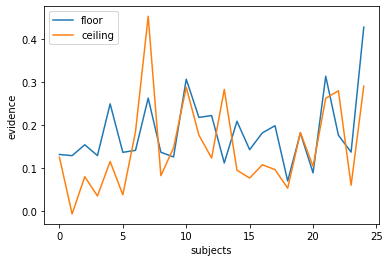

In [2]:


def getString(string,searchFor,end):
    return string.split(searchFor)[1].split(end)[0]

def getCeilFLoor(a):
    accs_rotation_container , evidence_rotation_container = a

    floors=[]
    ceils=[]
    for testRun in range(1,7):
        t=np.float(getString(evidence_rotation_container[testRun][2],"\nfloor=",","))
        floors.append(t)
        t=np.float(getString(evidence_rotation_container[testRun][2],", ceil=","\n"))
        ceils.append(t)

    print(np.mean(floors))
    print(np.mean(ceils))
    return np.mean(floors),np.mean(ceils)

floors=[]
ceilings=[]
for subject in subjects:
    floor,ceiling = getCeilFLoor(data[subject])
    floors.append(floor)
    ceilings.append(ceiling)

plt.plot(floors,label='floor')
plt.plot(ceilings,label="ceiling")
plt.legend()
plt.xlabel("subjects")
plt.ylabel("evidence")